## benchmarking on sushmita ROY's dataset


In [1]:
from scprint import scPrint
from scdataloader import Preprocessor
from scprint.tasks import GRNfer

from bengrn import BenGRN, get_sroy_gt, unnormalize
import scanpy as sc
from bengrn.base import train_classifier

from anndata.utils import make_index_unique
from bengrn import compute_genie3
from grnndata import utils as grnutils

%load_ext autoreload
%autoreload 2 

import torch
torch.set_float32_matmul_precision('medium')

💡 connected lamindb: jkobject/scprint


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/scib_metrics/_types.py:9: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.i

In [ ]:
# '../../data/main/gene_embeddings.parquet')
model = scPrint.load_from_checkpoint(
    '../data/temp/o2uniqsx/epoch=18-step=133000.ckpt', precpt_gene_emb=None)

MAXGENES = 5000

RuntimeError caught: scPrint is not attached to a `Trainer`.



In [3]:
preprocessor = Preprocessor(is_symbol=True, force_preprocess=True, skip_validate=True,
                            do_postp=False, min_valid_genes_id=5000, min_dataset_size=64)

## han / huma,n

In [4]:
preadata = get_sroy_gt(get="han", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 5520 renamining
filtered out 0 cells, 5520 renamining
Removed 0 genes.
startin QC
Seeing 151 outliers (2.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 5520 × 7465
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 8463 elements,
 31)

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=1024,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn, m, clf_omni = train_classifier(grn, C=1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.5, train_size=0.5, class_weight={1: 30, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7295


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

true elem 22920 ...
 22920 ...


In [55]:
Area Under Precision-Recall Curve (AUPRC):  0.05187147349671842
EPR: 1.6505755321153375

{'precision': 0.038948387096774194,
 'recall': 1.0,
 'rand_precision': 0.03895617833244068,
 'auprc': 0.057344924228559246,
 'epr': 1.762645450758292}

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3098427819.py, line 1)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7295


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24990001, sparsity: 1.0


... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.027385657820440428 
recall:  1.0 
random precision: 0.027391145928220076


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:717: RuntimeWarning: invalid value encountered in long_scalars
  metrics.update({"auprc": auprc})
100%|██████████| 99/99 [00:00<00:00, 3065.97it/s]


Area Under Precision-Recall Curve (AUPRC):  0.02689131442835298
EPR: 1.3614788917248497


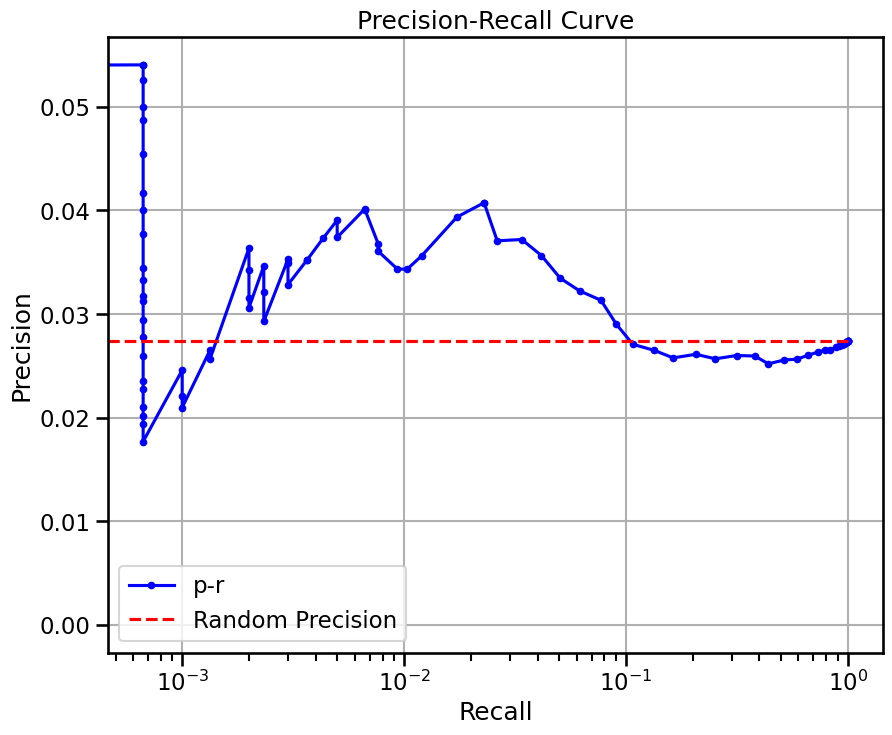

{'precision': 0.027385657820440428,
 'recall': 1.0,
 'rand_precision': 0.027391145928220076,
 'auprc': 0.02689131442835298,
 'epr': 1.3614788917248497}

In [43]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=1024,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## tran / mouse

In [45]:
preadata = get_sroy_gt(get="tran", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 2369 renamining
filtered out 0 cells, 2369 renamining
Removed 0 genes.
startin QC
Seeing 91 outliers (3.84% of total dataset):
done


(GRnnData object with n_obs × n_vars = 2369 × 6618
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7162 elements,
 31)

In [48]:
grn.var

,uid,symbol,ncbi_gene_ids,biotype,description,synonyms,organism_id,public_source_id,created_by_id,mt,...,pct_dropout_by_counts,total_counts,log1p_total_counts,isTF,highly_variable,highly_variable_rank,means,variances,variances_norm,TFs
ENSMUSG00000000037,1LV70e3sonOb,Scml2,107815,protein_coding,Scm polycomb group protein like 2 [Source:MGI ...,4932420G07Rik,1,11.0,1,False,...,96.243141,105.0,4.663439,False,True,3200.0,0.044322,0.055889,0.867313,False
ENSMUSG00000000056,3Y569auu9lnH,Narf,67608,protein_coding,nuclear prelamin A recognition factor [Source:...,4430402O11Rik,1,11.0,1,False,...,89.278176,309.0,5.736572,False,True,4384.0,0.130435,0.164990,0.784437,False
ENSMUSG00000000058,7R79lbqgSiIP,Cav2,12390,protein_coding,caveolin 2 [Source:MGI Symbol;Acc:MGI:107571],,1,11.0,1,False,...,59.434360,2500.0,7.824446,False,True,605.0,1.055298,4.109694,1.820098,False
ENSMUSG00000000078,30ZRk9TCBtV5,Klf6,23849,protein_coding,Kruppel-like factor 6 [Source:MGI Symbol;Acc:M...,Copeb|BCD1|CPBP|Zf9|FM2|Ierepo3|FM6|Ierepo1,1,11.0,1,False,...,33.600675,7927.0,8.978156,False,True,575.0,3.346138,26.014429,1.857694,False
ENSMUSG00000000085,1XKsHNwJqVke,Scmh1,29871,protein_coding,sex comb on midleg homolog 1 [Source:MGI Symbo...,Scml3,1,11.0,1,False,...,74.419586,829.0,6.721426,False,True,3947.0,0.349937,0.496158,0.809819,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSMUSG00000116564,6JsowFqnty5p,Riok2,67045,protein_coding,RIO kinase 2 [Source:MGI Symbol;Acc:MGI:1914295],2410085M17Rik|2010110K24Rik,1,11.0,1,False,...,40.818911,2974.0,7.997999,False,True,4030.0,1.255382,2.351560,0.804044,False
ENSMUSG00000118664,2kfEKHl6Mut2,Tusc3,80286,protein_coding,tumor suppressor candidate 3 [Source:MGI Symbo...,,1,11.0,1,False,...,76.994512,761.0,6.635947,False,True,3221.0,0.321233,0.481648,0.865906,False
ENSMUSG00000118668,5Nspoaz2HgZz,Rps6ka4,56613,protein_coding,"ribosomal protein S6 kinase, polypeptide 4 [So...",MSK2|90kDa|1110069D02Rik,1,11.0,1,False,...,46.053187,2834.0,7.949797,False,True,2847.0,1.196285,2.454277,0.904036,False
ENSMUSG00000118669,25qU6rREefIh,Arvcf,11877,protein_coding,armadillo repeat gene deleted in velocardiofac...,,1,11.0,1,False,...,63.993246,1344.0,7.204149,False,True,3028.0,0.567328,0.930537,0.884932,False


precision:  0.04014336917562724 
recall:  1.0 
random precision: 0.04015140749544615


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:717: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1168.46it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03774411287510102
EPR: 0.7753059267572165


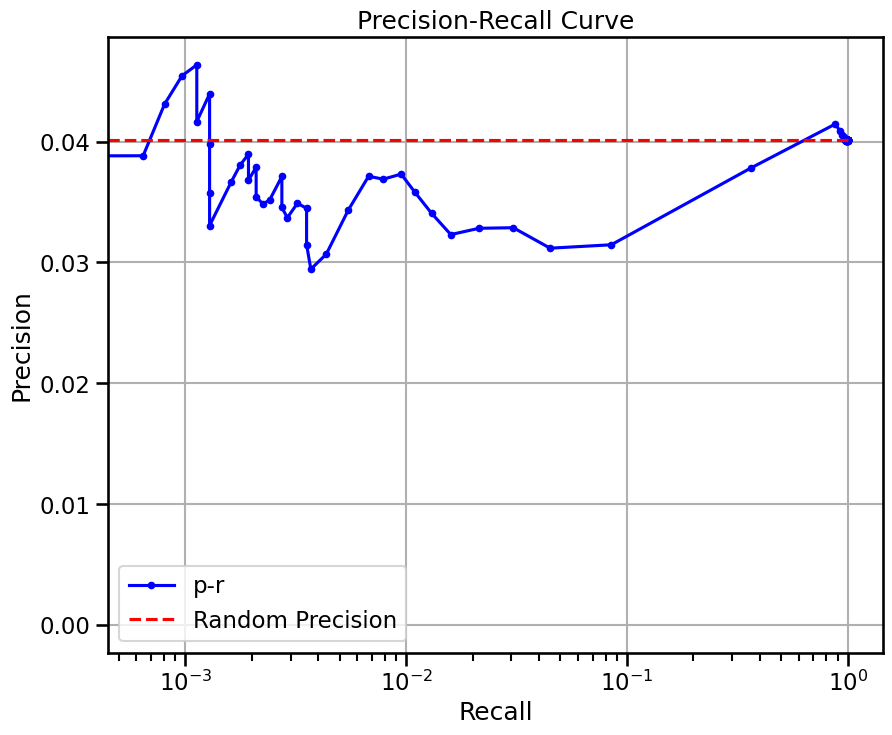

pred shape (31, 4995, 32)
true elem 6216 ...
doing regression....
metrics {'used_heads': 13, 'precision': 0.038582880786139126, 'random_precision': 0.03854151867016261, 'recall': 1.0, 'predicted_true': 77340.0, 'number_of_true': 2984.0, 'epr': 1.357102245523317}


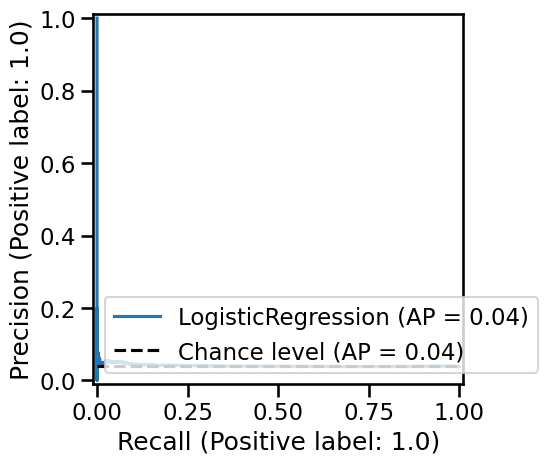

precision:  0.04014336917562724 
recall:  1.0 
random precision: 0.04015140749544615


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:717: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1214.82it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0509202665447579
EPR: 1.6118364973722388


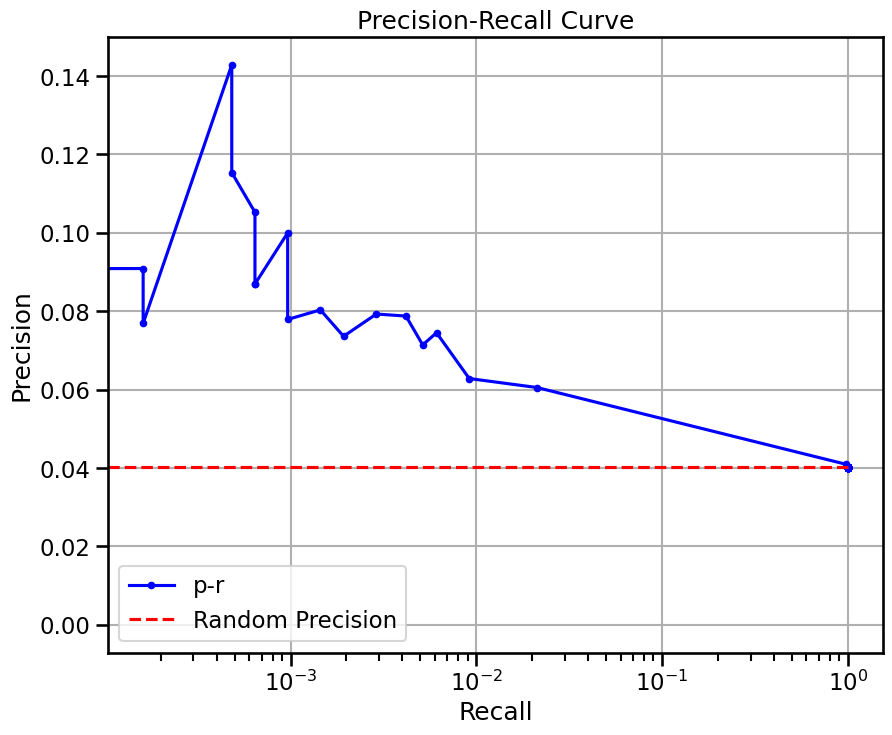

{'precision': 0.04014336917562724,
 'recall': 1.0,
 'rand_precision': 0.04015140749544615,
 'auprc': 0.0509202665447579,
 'epr': 1.6118364973722388}

In [49]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=1024,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.5, train_size=0.5, class_weight={1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 6435


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24980004, sparsity: 1.0


... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.040534915985817786 
recall:  1.0 
random precision: 0.0405430408437023


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:717: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1693.10it/s]


Area Under Precision-Recall Curve (AUPRC):  0.03820605331096389
EPR: 1.1275206173505652


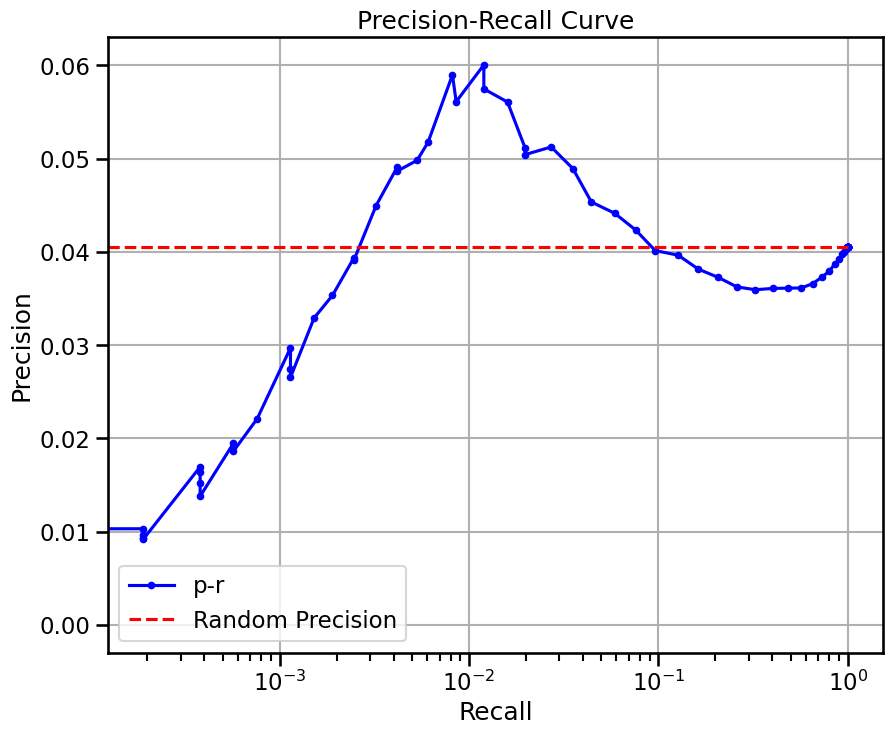

{'precision': 0.040534915985817786,
 'recall': 1.0,
 'rand_precision': 0.0405430408437023,
 'auprc': 0.03820605331096389,
 'epr': 1.1275206173505652}

In [50]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=1024,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## zhao / mouse

In [51]:
preadata = get_sroy_gt(get="zhao", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 36199 renamining
filtered out 0 cells, 36199 renamining
Removed 0 genes.
startin QC
Seeing 828 outliers (2.29% of total dataset):
done


(GRnnData object with n_obs × n_vars = 36199 × 8442
     obs: 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 9019 elements,
 34)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8220


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.03922571692333022 
recall:  1.0 
random precision: 0.03923332980462731


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:711: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:717: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 706.53it/s]


Area Under Precision-Recall Curve (AUPRC):  0.042917149271050954
EPR: 1.0218680909144464


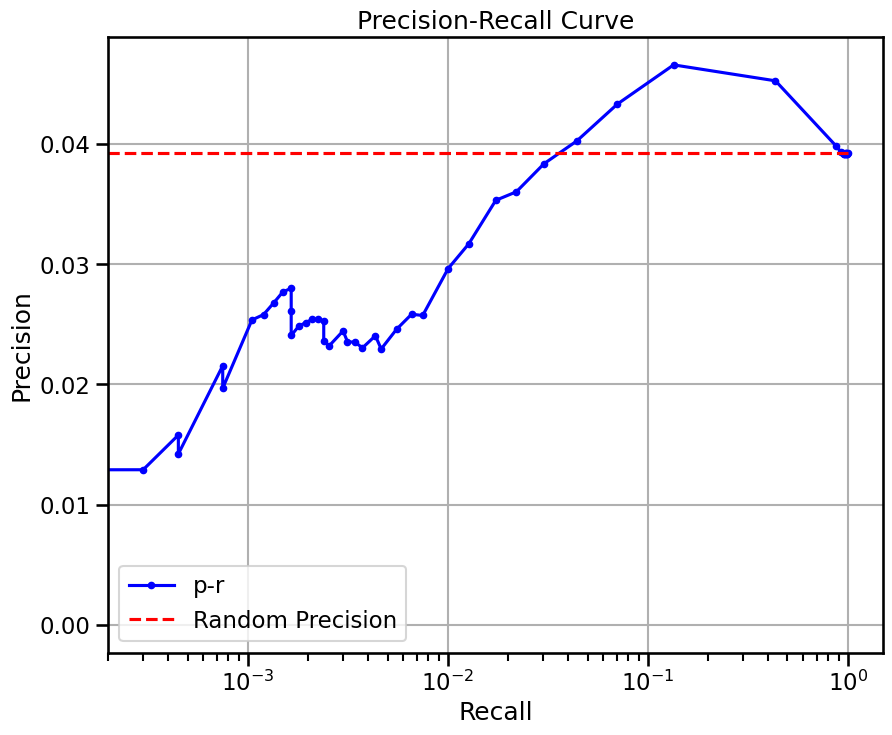

pred shape (34, 5002, 32)
true elem 6671 ...
doing regression....
metrics {'used_heads': 8, 'precision': 0.028921926089717956, 'random_precision': 0.02891784462685514, 'recall': 1.0, 'predicted_true': 85022.0, 'number_of_true': 2459.0, 'epr': 1.425826809824763}


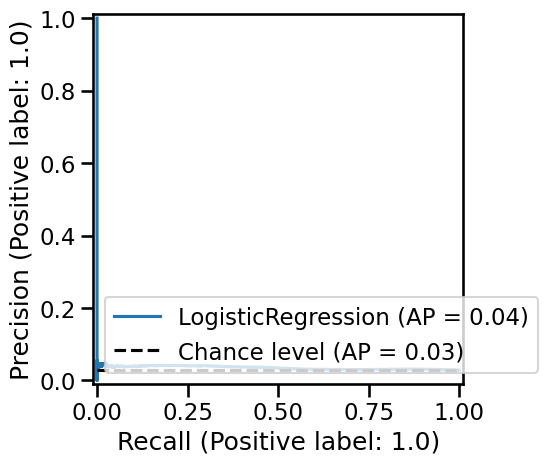

precision:  0.0392254862760778 
recall:  1.0 
random precision: 0.03923332980462731


 66%|██████▌   | 65/99 [00:00<00:00, 648.89it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:717: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 715.77it/s]


Area Under Precision-Recall Curve (AUPRC):  0.04704928573395035
EPR: 1.3146893300832436


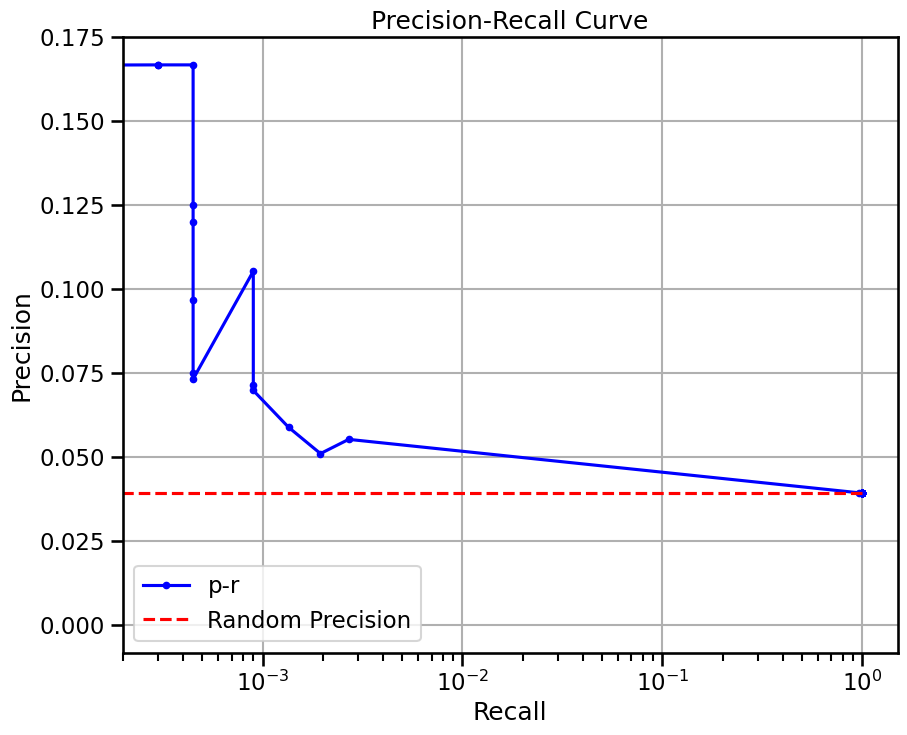

{'precision': 0.0392254862760778,
 'recall': 1.0,
 'rand_precision': 0.03923332980462731,
 'auprc': 0.04704928573395035,
 'epr': 1.3146893300832436}

In [52]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=1024,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, clf_self = train_classifier(
    grn, other=preadata, C=0.5, train_size=0.5, class_weight={1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 8220


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24980004, sparsity: 1.0


... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.051739843323009654 
recall:  1.0 
random precision: 0.05175021410739992


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:717: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 996.41it/s]


Area Under Precision-Recall Curve (AUPRC):  0.05199757382335156
EPR: 0.9288372622396264


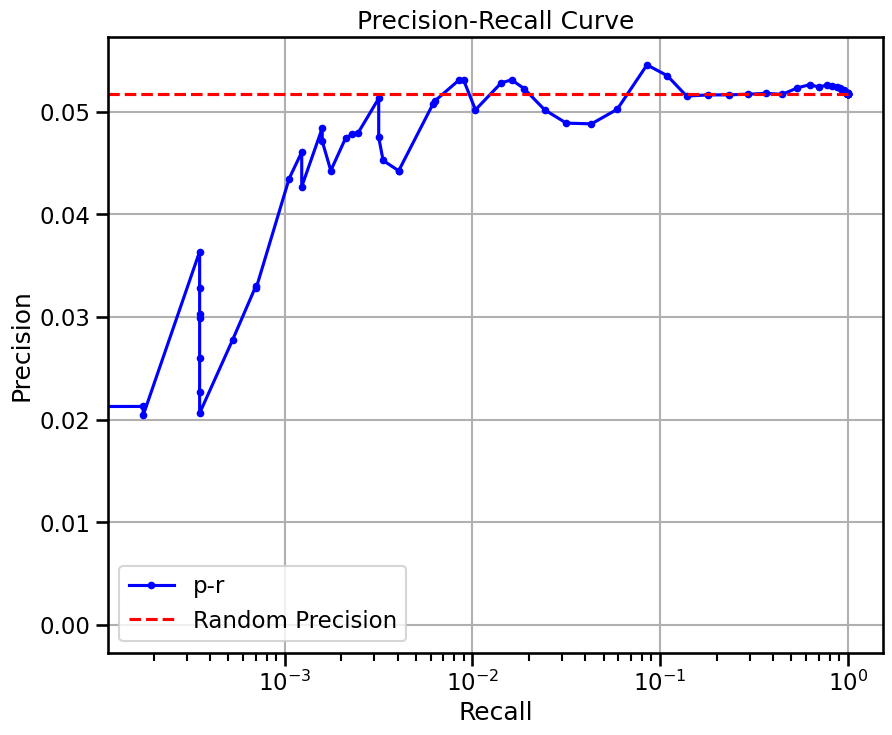

{'precision': 0.051739843323009654,
 'recall': 1.0,
 'rand_precision': 0.05175021410739992,
 'auprc': 0.05199757382335156,
 'epr': 0.9288372622396264}

In [53]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     genes=adata.var[adata.var.symbol.isin(preadata.var[preadata.grn.sum(1) != 0].index.tolist())].index.tolist(),
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=1024,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# liu / chip


In [4]:
preadata = get_sroy_gt(get="liu", species="human", gt="chip")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 72 renamining
filtered out 0 cells, 72 renamining
Removed 0 genes.
startin QC
Seeing 4 outliers (5.56% of total dataset):
done


(GRnnData object with n_obs × n_vars = 72 × 23153
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 435395 elements,
 90)

/tmp/ipykernel_1455512/3297281218.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 11725 ...
doing regression....
metrics {'used_heads': 26, 'precision': 0.003257328990228013, 'random_precision': 0.0010413009987395255, 'recall': 0.0026200873362445414, 'predicted_true': 921.0, 'number_of_true': 1145.0, 'epr': 2.5241434359482398}


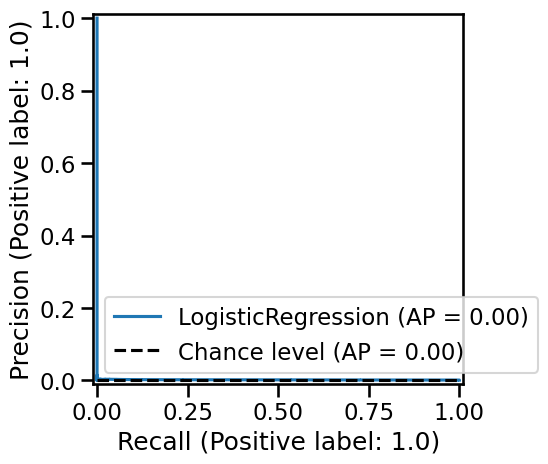

precision:  0.2787887394860341 
recall:  0.9999768459561462 
random precision: 0.27879699442263994


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 26%|██▋       | 26/99 [00:00<00:00, 257.16it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 432.03it/s]


Area Under Precision-Recall Curve (AUPRC):  0.29922428711788013
EPR: 1.2241638970691204


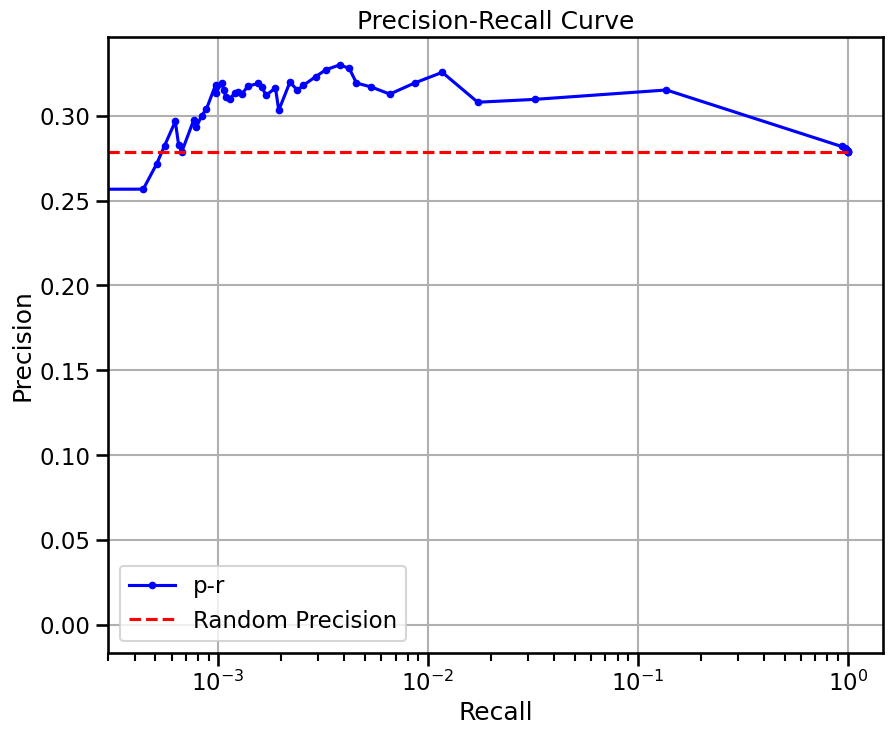

pred shape (32, 4842, 32)
true elem 43189 ...
doing regression....
metrics {'used_heads': 7, 'precision': 0.30987539314339474, 'random_precision': 0.30977033219313854, 'recall': 0.9999702363235907, 'predicted_true': 108421.0, 'number_of_true': 33598.0, 'epr': 1.525671951322129}


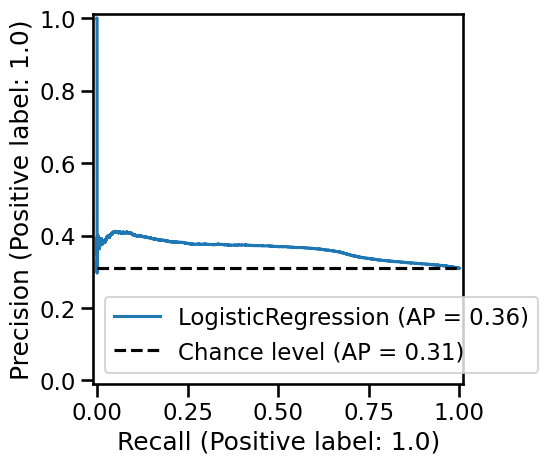

precision:  0.2787394155307724 
recall:  1.0 
random precision: 0.27879699442263994


 92%|█████████▏| 91/99 [00:00<00:00, 482.90it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 458.76it/s]


Area Under Precision-Recall Curve (AUPRC):  0.2972235127368131
EPR: 1.6116498052658546


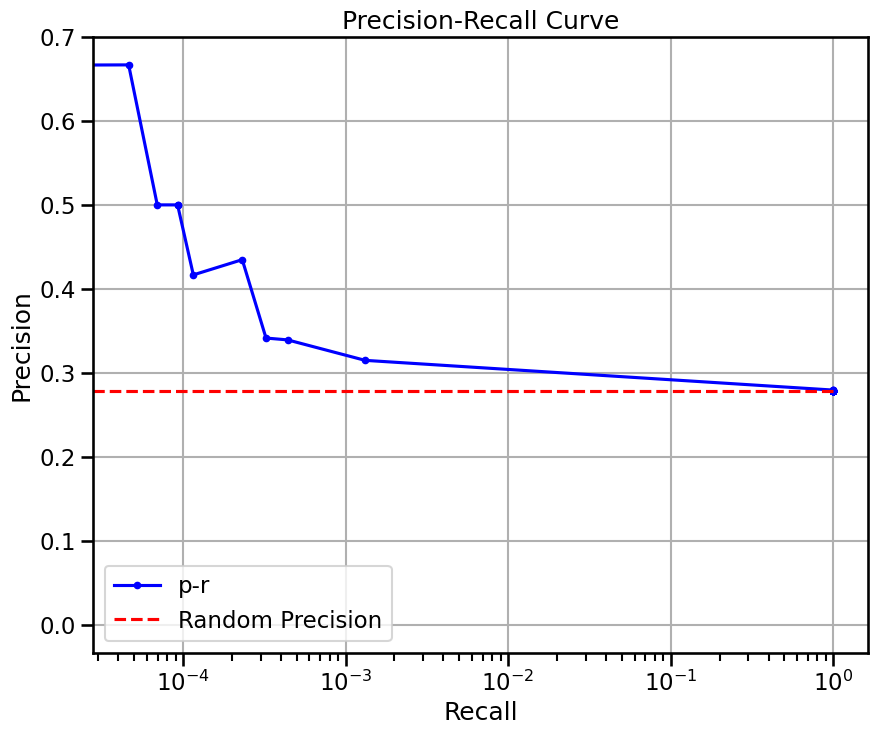

{'precision': 0.2787394155307724,
 'recall': 1.0,
 'rand_precision': 0.27879699442263994,
 'auprc': 0.2972235127368131,
 'EPR': 1.6116498052658546}

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
# grn.varp["classified"] = clf_omni.predict_proba(
#    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
# ).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn, m, clf_omni2 = train_classifier(grn, C=1, train_size=0.9, class_weight={
    1: 200, 0: 1}, shuffle=True)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.3, class_weight={
                             1: 10, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 23522500, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.2787394155307724 
recall:  1.0 
random precision: 0.27879699442263994


 67%|██████▋   | 66/99 [00:00<00:00, 655.05it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 677.57it/s]


Area Under Precision-Recall Curve (AUPRC):  0.2813312425452778
EPR: 1.0379366039470581


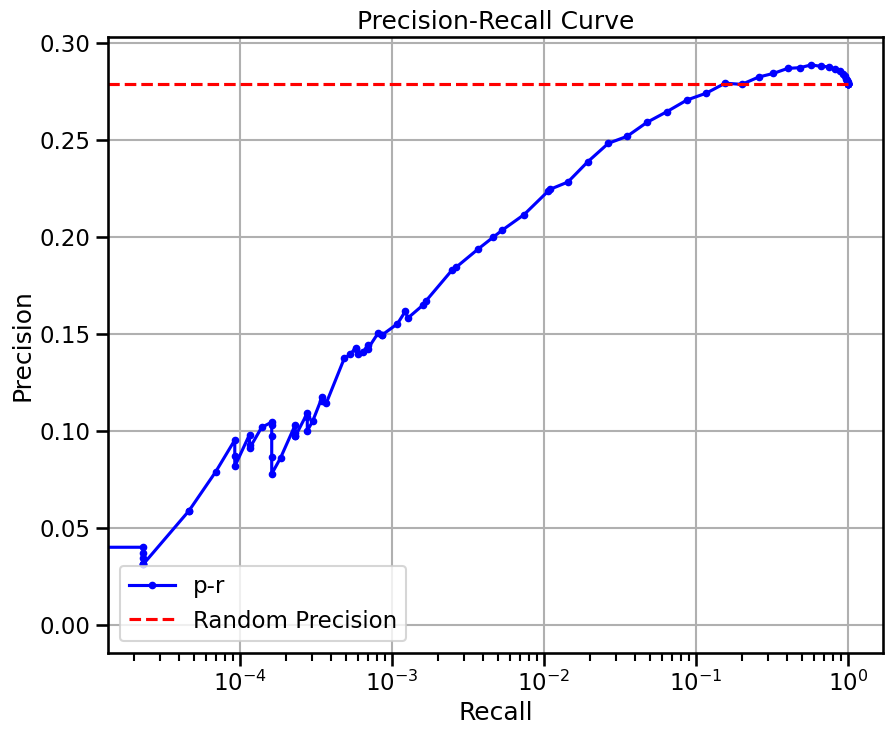

{'precision': 0.2787394155307724,
 'recall': 1.0,
 'rand_precision': 0.27879699442263994,
 'auprc': 0.2813312425452778,
 'EPR': 1.0379366039470581}

In [6]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

## liu / ko


In [4]:
preadata = get_sroy_gt(get="liu", species="human", gt="ko")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 72 renamining
filtered out 0 cells, 72 renamining
Removed 0 genes.
startin QC
Seeing 4 outliers (5.56% of total dataset):
done


(GRnnData object with n_obs × n_vars = 72 × 23153
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 108194 elements,
 157)

/tmp/ipykernel_1486605/3217281525.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 16947


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical
/home/ml4ig1/Documents code/benGRN/bengrn/base.py:270: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(genes), len(genes)), dtype=np.float)


true elem 11725 ...
doing regression....
metrics {'used_heads': 26, 'precision': 0.003257328990228013, 'random_precision': 0.0010413009987395255, 'recall': 0.0026200873362445414, 'predicted_true': 921.0, 'number_of_true': 1145.0, 'epr': 2.5241434359482398}


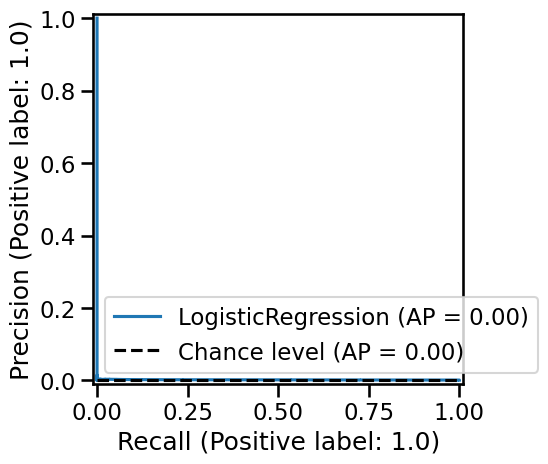

precision:  0.05675878689242903 
recall:  1.0 
random precision: 0.05675949747422584


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 597.44it/s]


Area Under Precision-Recall Curve (AUPRC):  0.0673361420855374
EPR: 1.3307970484146516


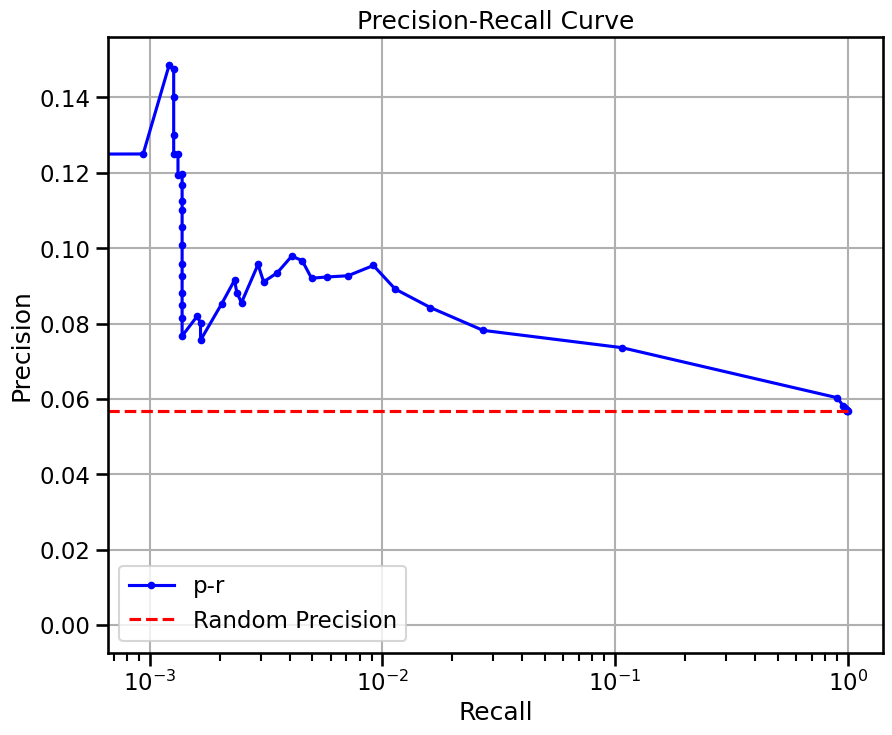

pred shape (66, 4842, 32)
true elem 18135 ...
doing regression....
metrics {'used_heads': 2, 'precision': 0.0, 'random_precision': 0.05822951171429721, 'recall': 0.0, 'predicted_true': 4.0, 'number_of_true': 13026.0, 'epr': 0.925551074793662}


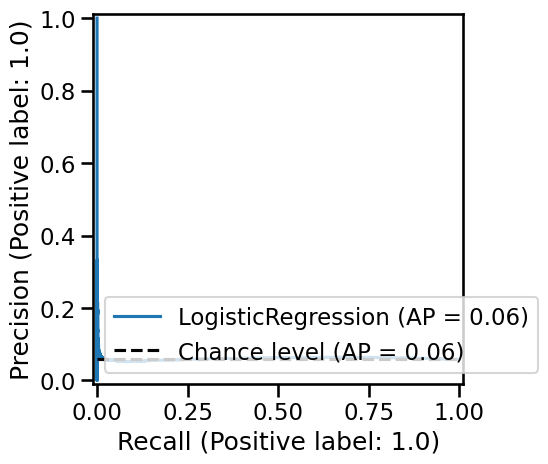

precision:  0.05674777514926214 
recall:  1.0 
random precision: 0.05675949747422584


 48%|████▊     | 48/99 [00:00<00:00, 477.12it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 590.59it/s]


Area Under Precision-Recall Curve (AUPRC):  0.05383092843539151
EPR: 0.8534768392694666


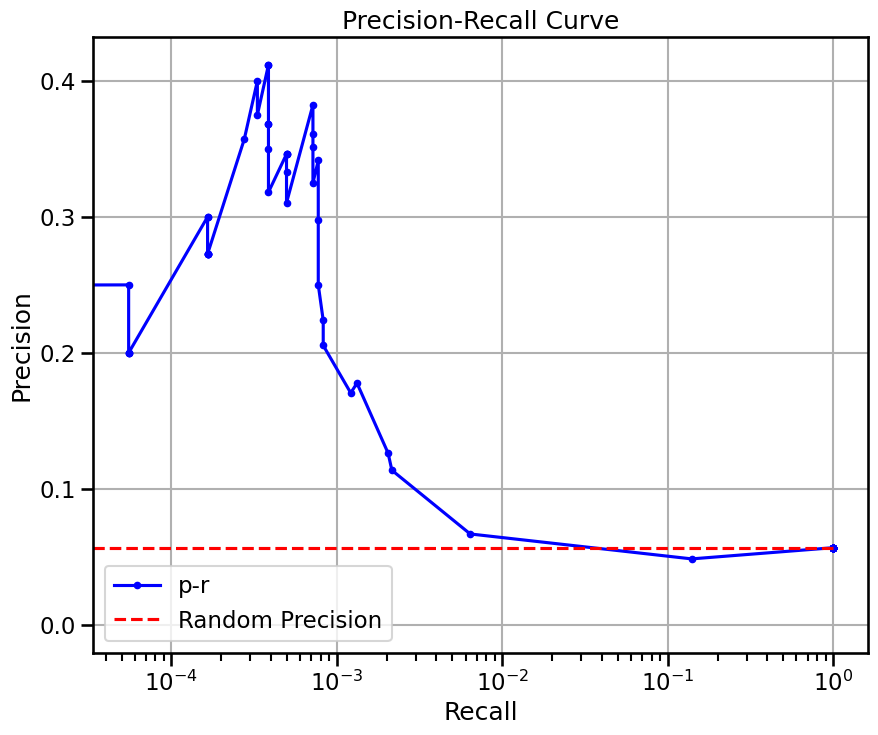

{'precision': 0.05674777514926214,
 'recall': 1.0,
 'rand_precision': 0.05675949747422584,
 'auprc': 0.05383092843539151,
 'EPR': 0.8534768392694666}

In [5]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
# grn.varp["classified"] = clf_omni.predict_proba(
#    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
# ).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn, m, clf_omni = train_classifier(grn, C=1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.2, train_size=0.3, class_weight={
                             1: 10, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

pred shape (66, 4842, 32)
true elem 18135 ...
doing regression....
metrics {'used_heads': 17, 'precision': 0.058875611456129004, 'random_precision': 0.058753582917151694, 'recall': 0.9987217724755006, 'predicted_true': 159251.0, 'number_of_true': 9388.0, 'epr': 1.1190480067552397}


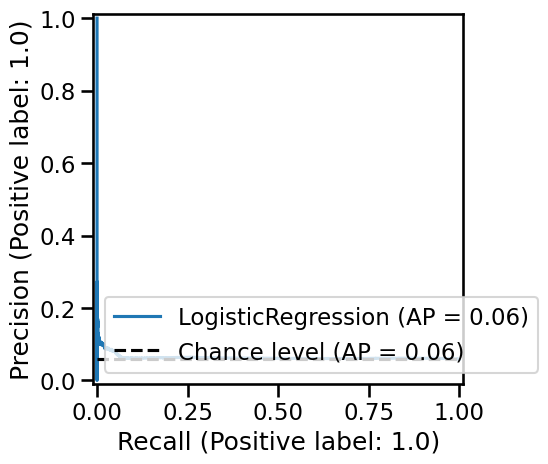

precision:  0.05674777514926214 
recall:  1.0 
random precision: 0.05675949747422584


 54%|█████▎    | 53/99 [00:00<00:00, 529.59it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 608.01it/s]


Area Under Precision-Recall Curve (AUPRC):  0.08369191716921298
EPR: 1.6171541123236626


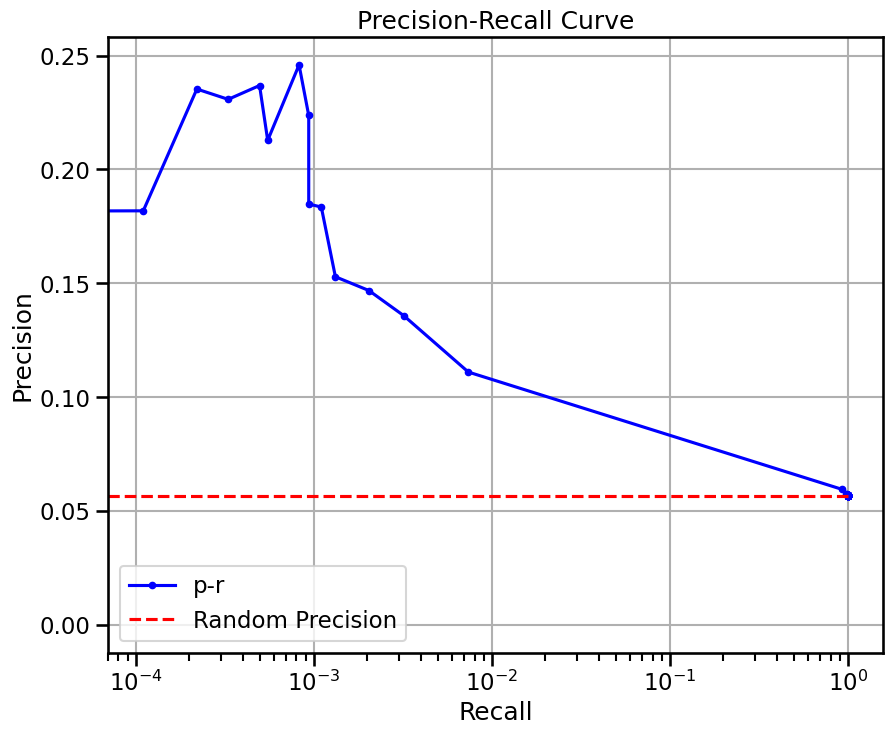

{'precision': 0.05674777514926214,
 'recall': 1.0,
 'rand_precision': 0.05675949747422584,
 'auprc': 0.08369191716921298,
 'EPR': 1.6171541123236626}

In [7]:
grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# chen / all


In [11]:
preadata = get_sroy_gt(get="chen", species="human", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


(GRnnData object with n_obs × n_vars = 385 × 8595
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 2969 elements,
 19)

/tmp/ipykernel_1455512/1308650287.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7906


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.017410924132744195 
recall:  1.0 
random precision: 0.01741452589611464


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 4640.18it/s]


Area Under Precision-Recall Curve (AUPRC):  0.025759130607077397
EPR: 1.7829772669778423


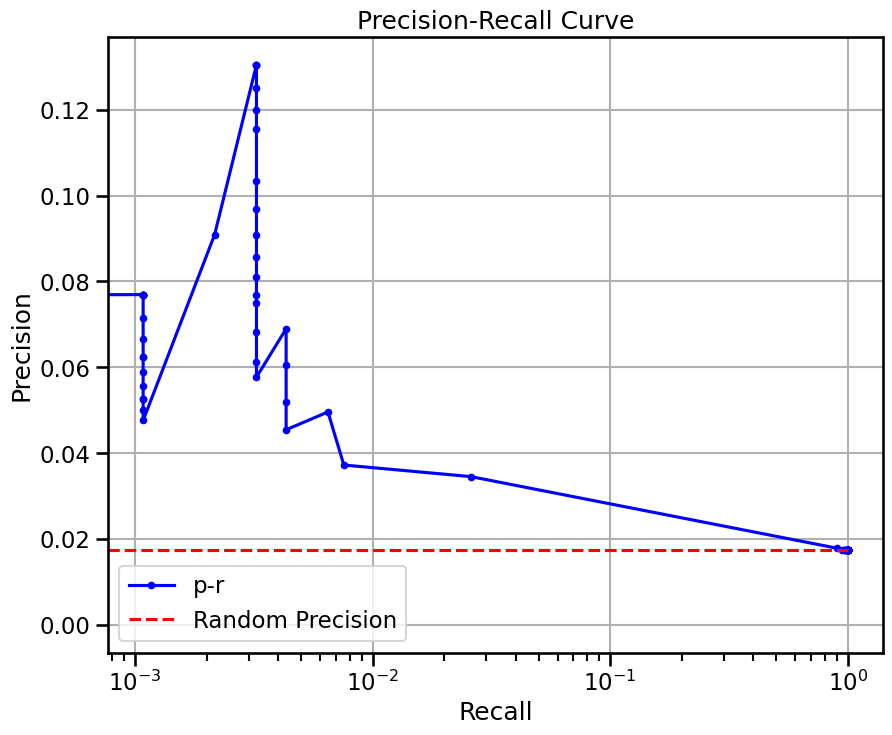

pred shape (11, 4835, 32)
true elem 926 ...
doing regression....
metrics {'used_heads': 1, 'precision': 0.00394842868654311, 'random_precision': 0.00394842868654311, 'recall': 1.0, 'predicted_true': 37230.0, 'number_of_true': 147.0, 'epr': 1.7328297992118595}


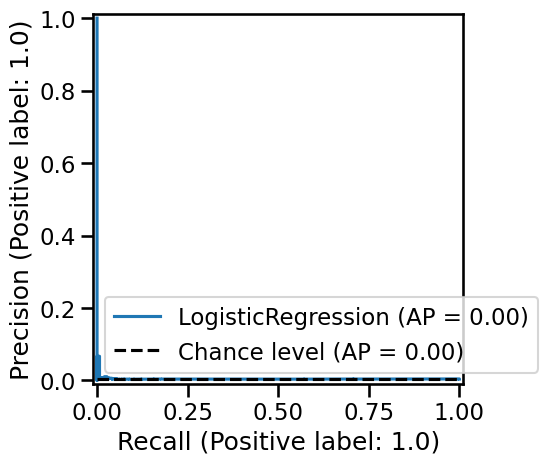

precision:  0.017410924132744195 
recall:  1.0 
random precision: 0.01741452589611464


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 4390.27it/s]


Area Under Precision-Recall Curve (AUPRC):  0.1088814022220448
EPR: 1.3164469949024755


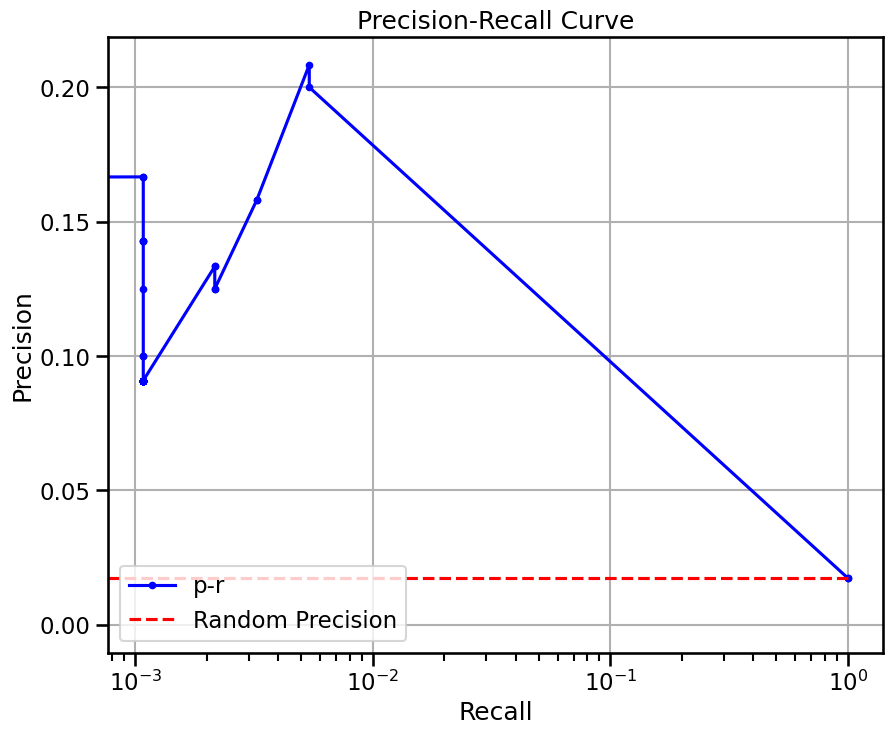

{'precision': 0.017410924132744195,
 'recall': 1.0,
 'rand_precision': 0.01741452589611464,
 'auprc': 0.1088814022220448,
 'EPR': 1.3164469949024755}

In [12]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.1, train_size=0.3, class_weight={
                             1: 100, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7906


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 23454649, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.017410924132744195 
recall:  1.0 
random precision: 0.01741452589611464


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 4329.34it/s]


Area Under Precision-Recall Curve (AUPRC):  0.017804259480311467
EPR: 1.12087368278057


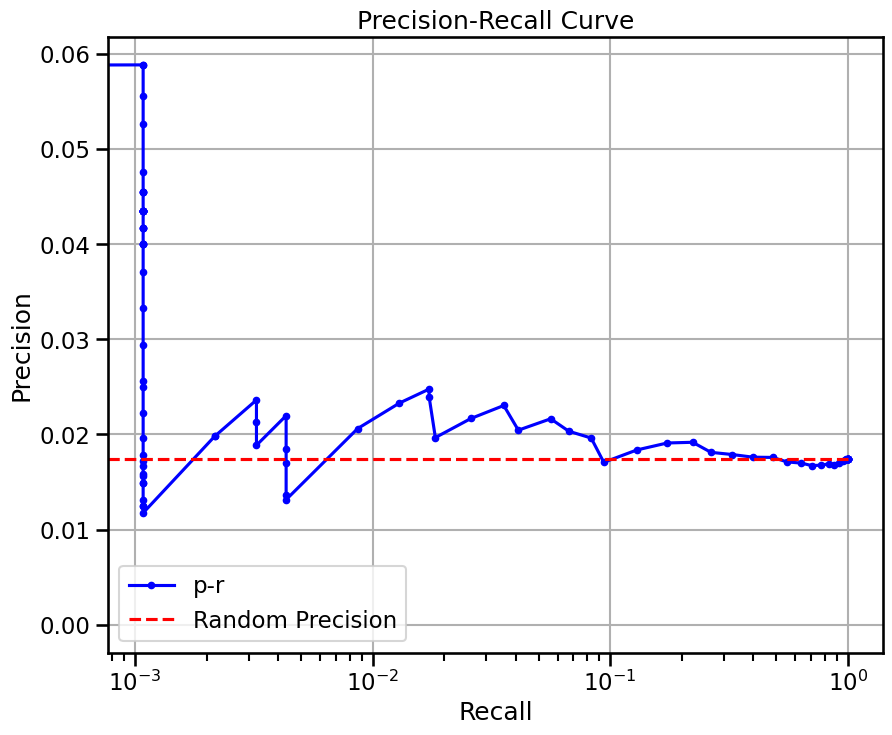

{'precision': 0.017410924132744195,
 'recall': 1.0,
 'rand_precision': 0.01741452589611464,
 'auprc': 0.017804259480311467,
 'EPR': 1.12087368278057}

In [13]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# chen / chip


In [19]:
preadata = get_sroy_gt(get="chen", species="human", gt="chip")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


(GRnnData object with n_obs × n_vars = 385 × 8595
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 187791 elements,
 60)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7906


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


true elem 13429 ...
doing regression....
metrics {'used_heads': 23, 'precision': 0.0, 'random_precision': 0.00116228083095084, 'recall': 0.0, 'predicted_true': 167.0, 'number_of_true': 1381.0, 'epr': 3.130450581395349}


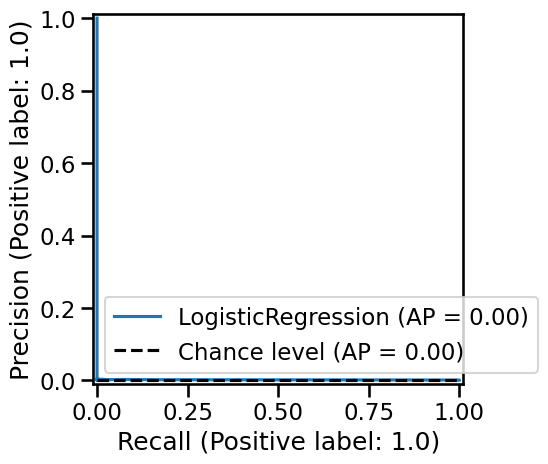

precision:  0.3378283350568769 
recall:  1.0 
random precision: 0.33789822093504346


 58%|█████▊    | 57/99 [00:00<00:00, 518.52it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:693: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 539.33it/s]


Area Under Precision-Recall Curve (AUPRC):  0.3870064065933639
EPR: 1.8800156309853855


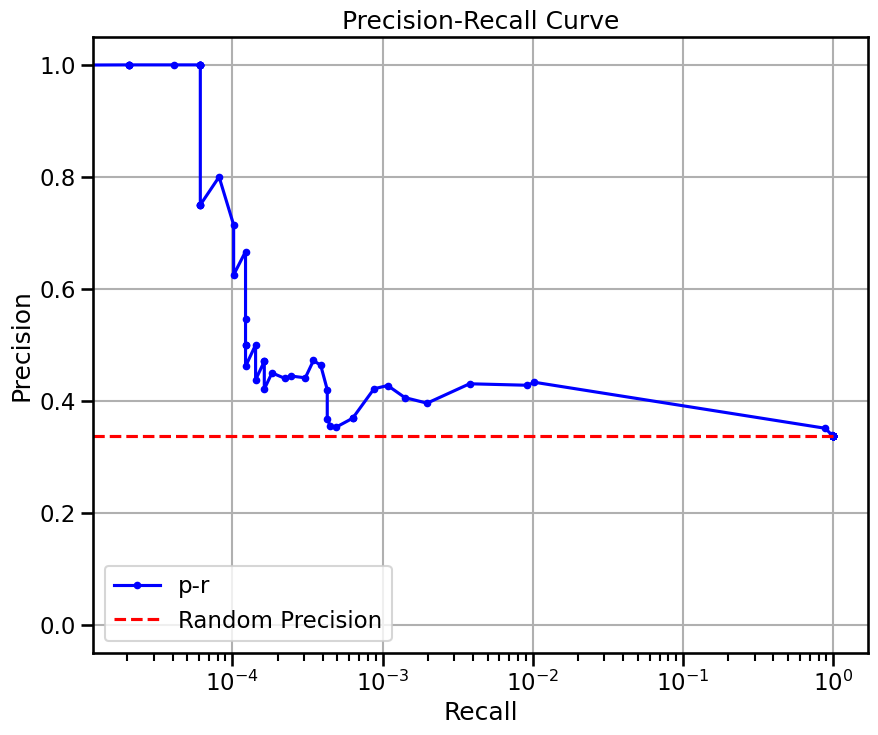

pred shape (30, 4835, 32)
true elem 49002 ...
doing regression....
metrics {'used_heads': 1, 'precision': 0.3331816301199835, 'random_precision': 0.3331540847983454, 'recall': 0.9998758380928731, 'predicted_true': 72510.0, 'number_of_true': 24162.0, 'epr': 1.6901031958005543}


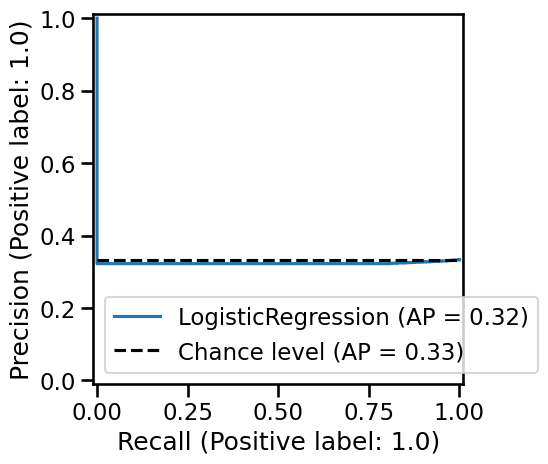

precision:  0.3378283350568769 
recall:  1.0 
random precision: 0.33789822093504346


 48%|████▊     | 48/99 [00:00<00:00, 476.72it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:693: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 580.94it/s]


Area Under Precision-Recall Curve (AUPRC):  0.16895027319919886
EPR: 0.815152305689571


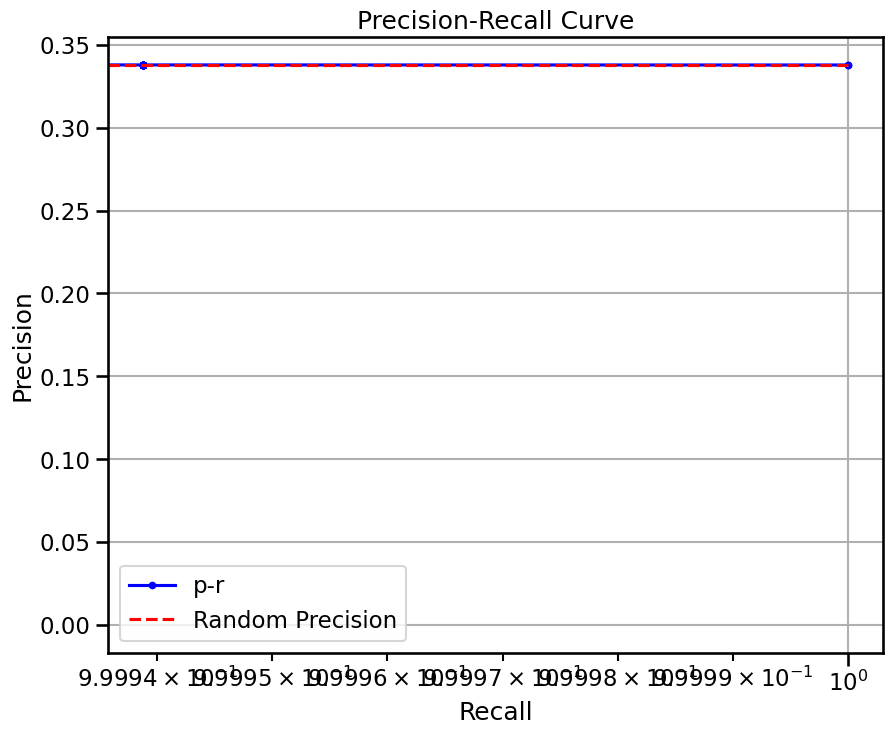

{'precision': 0.3378283350568769,
 'recall': 1.0,
 'rand_precision': 0.33789822093504346,
 'auprc': 0.16895027319919886,
 'epr': 0.815152305689571}

In [20]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
#grn.varp["classified"] = clf_omni.predict_proba(
#    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
#).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn, m, clf_omni = train_classifier(grn, C=1, train_size=0.9, class_weight={
                                    1: 100, 0: 1}, shuffle=True)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 3, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7906


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 23454649, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.3378283350568769 
recall:  1.0 
random precision: 0.33789822093504346


 59%|█████▊    | 58/99 [00:00<00:00, 575.44it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:693: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 650.44it/s]


Area Under Precision-Recall Curve (AUPRC):  0.33375849536299174
EPR: 0.9226595816712351


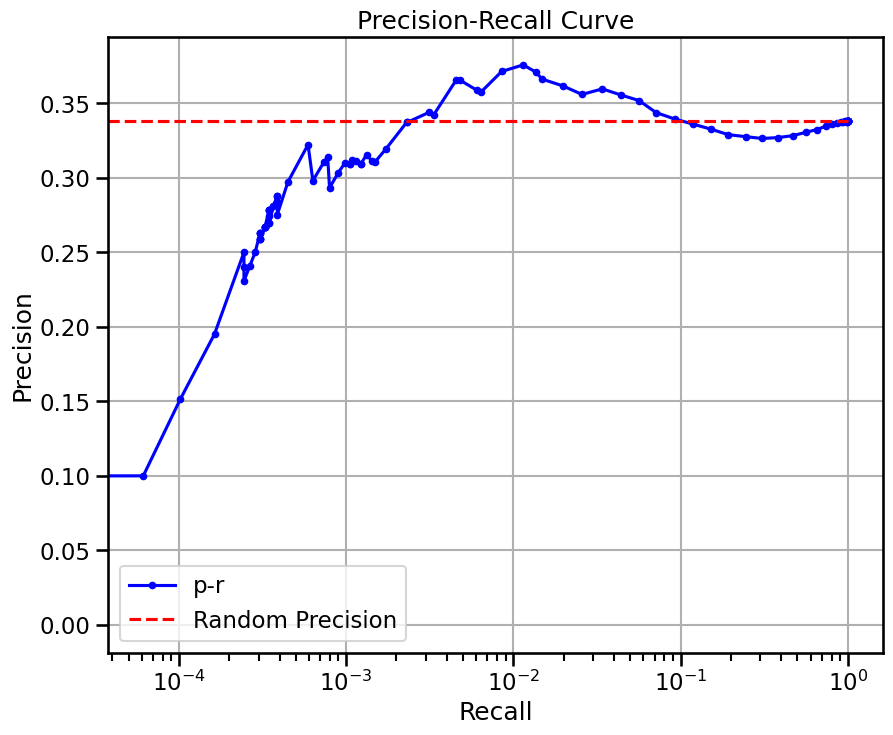

{'precision': 0.3378283350568769,
 'recall': 1.0,
 'rand_precision': 0.33789822093504346,
 'auprc': 0.33375849536299174,
 'epr': 0.9226595816712351}

In [13]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# chen / ko

In [14]:
preadata = get_sroy_gt(get="chen", species="human", gt="ko")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.TF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 385 renamining
filtered out 0 cells, 385 renamining
Removed 0 genes.
startin QC
Seeing 38 outliers (9.87% of total dataset):
done


(GRnnData object with n_obs × n_vars = 385 × 8595
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 14996 elements,
 83)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7906


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


true elem 13429 ...
doing regression....
metrics {'used_heads': 24, 'precision': 0.0032, 'random_precision': 0.00116228083095084, 'recall': 0.001448225923244026, 'predicted_true': 625.0, 'number_of_true': 1381.0, 'epr': 3.130450581395349}


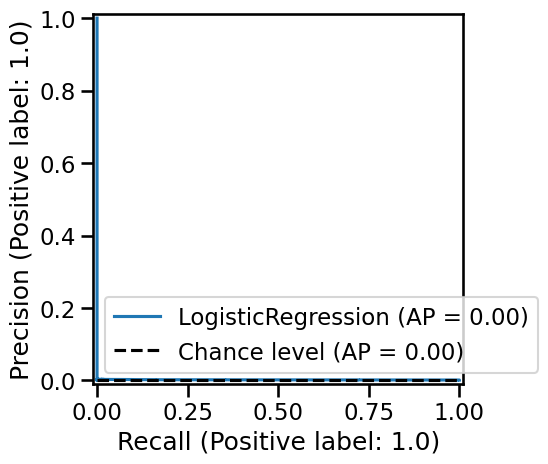

precision:  0.02272013481941093 
recall:  1.0 
random precision: 0.02272483488867436


 64%|██████▎   | 63/99 [00:00<00:00, 624.53it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:693: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 707.96it/s]


Area Under Precision-Recall Curve (AUPRC):  0.020487601636720608
EPR: 0.7253088851777055


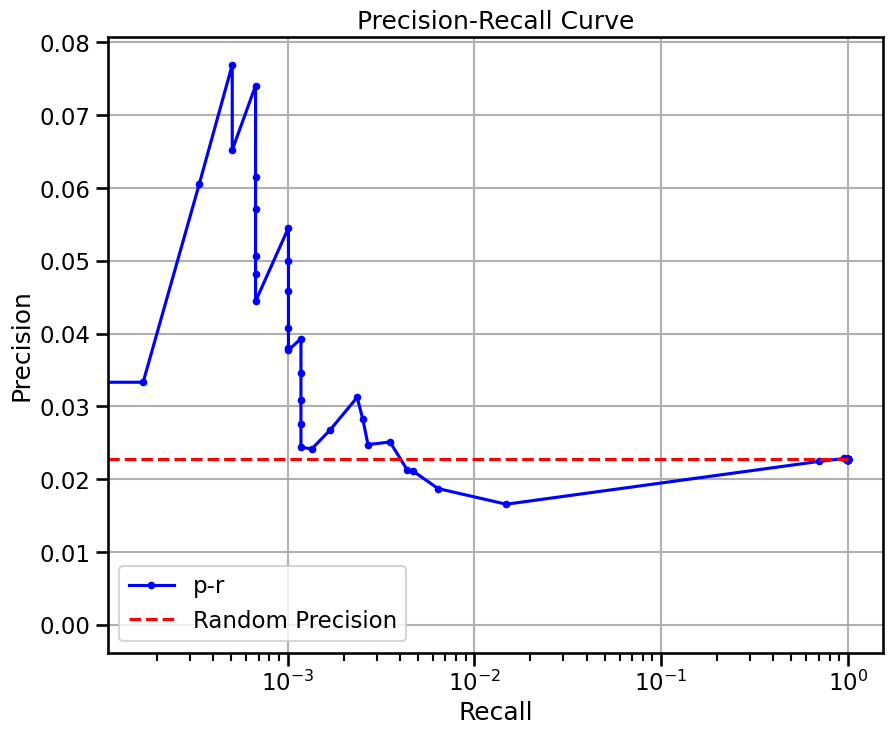

pred shape (54, 4835, 32)
true elem 5932 ...
doing regression....
metrics {'used_heads': 0, 'precision': 0.02705142725825249, 'random_precision': 0.02705142725825249, 'recall': 1.0, 'predicted_true': 182763.0, 'number_of_true': 4944.0, 'epr': 3.3369915275807025}


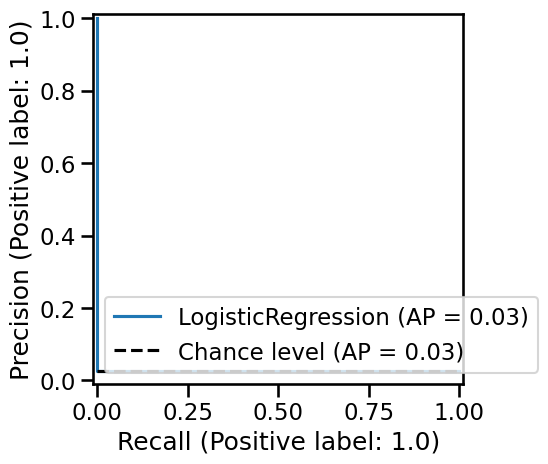

precision:  0.02272013481941093 
recall:  1.0 
random precision: 0.02272483488867436


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:693: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 998.25it/s]


Area Under Precision-Recall Curve (AUPRC):  0.011360067409705465
EPR: 0.5077239373787724


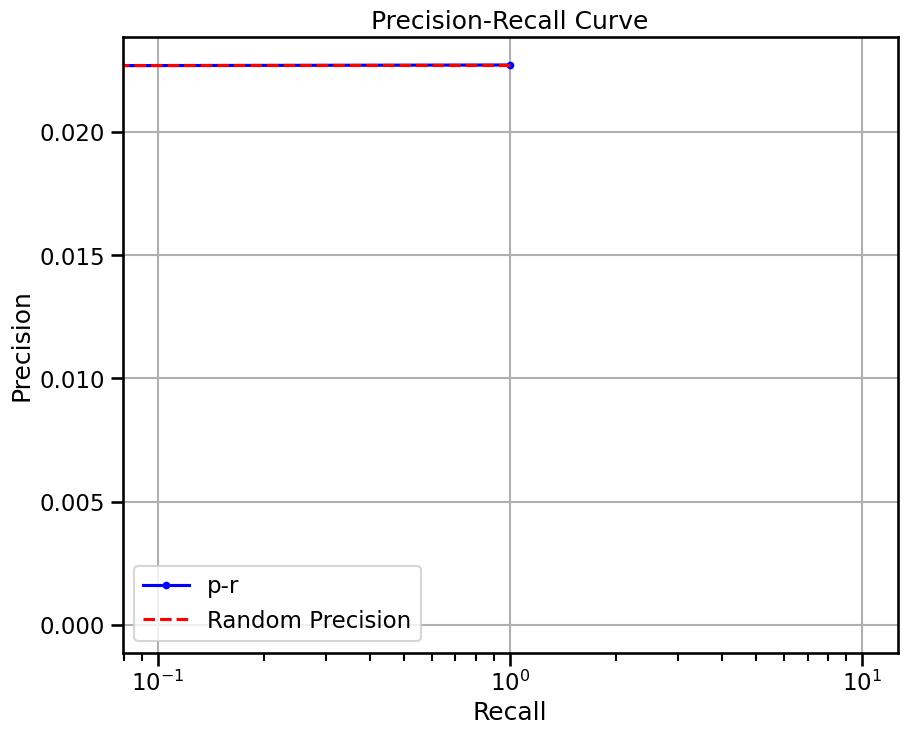

{'precision': 0.02272013481941093,
 'recall': 1.0,
 'rand_precision': 0.02272483488867436,
 'auprc': 0.011360067409705465,
 'epr': 0.5077239373787724}

In [16]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
#grn.varp["classified"] = clf_omni.predict_proba(
#    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
#).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn, m, clf_omni = train_classifier(grn, C=1, train_size=0.9, class_weight={
                                    1: 200, 0: 1}, shuffle=True)
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.1, train_size=0.3, class_weight={
                             1: 100, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

pred shape (54, 4835, 32)
true elem 5932 ...
doing regression....
metrics {'used_heads': 11, 'precision': 0.045454545454545456, 'random_precision': 0.029246619939484467, 'recall': 0.0005238344683080147, 'predicted_true': 44.0, 'number_of_true': 3818.0, 'epr': 1.3028968300245267}


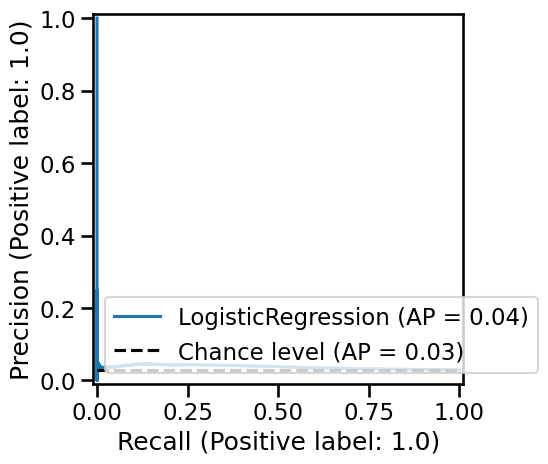

precision:  0.02272013481941093 
recall:  1.0 
random precision: 0.02272483488867436


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:693: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1131.11it/s]


Area Under Precision-Recall Curve (AUPRC):  0.02814202591825364
EPR: 1.3006265346816224


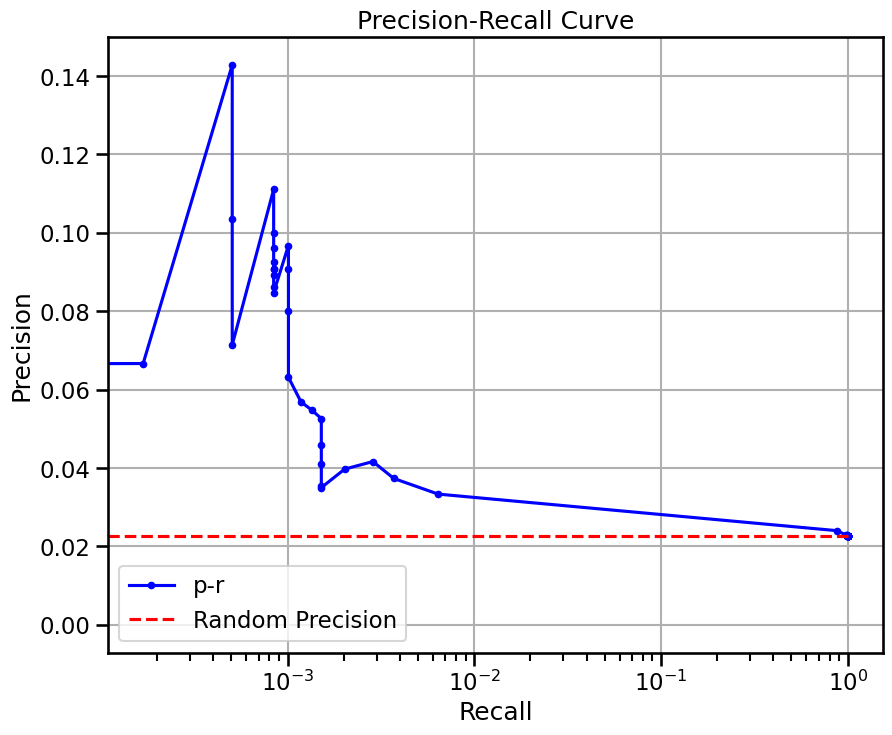

{'precision': 0.02272013481941093,
 'recall': 1.0,
 'rand_precision': 0.02272483488867436,
 'auprc': 0.02814202591825364,
 'epr': 1.3006265346816224}

In [17]:
grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 30, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 7906


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 23454649, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.02272013481941093 
recall:  1.0 
random precision: 0.02272483488867436


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:693: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1093.81it/s]


Area Under Precision-Recall Curve (AUPRC):  0.02187076803680548
EPR: 1.0092955756831894


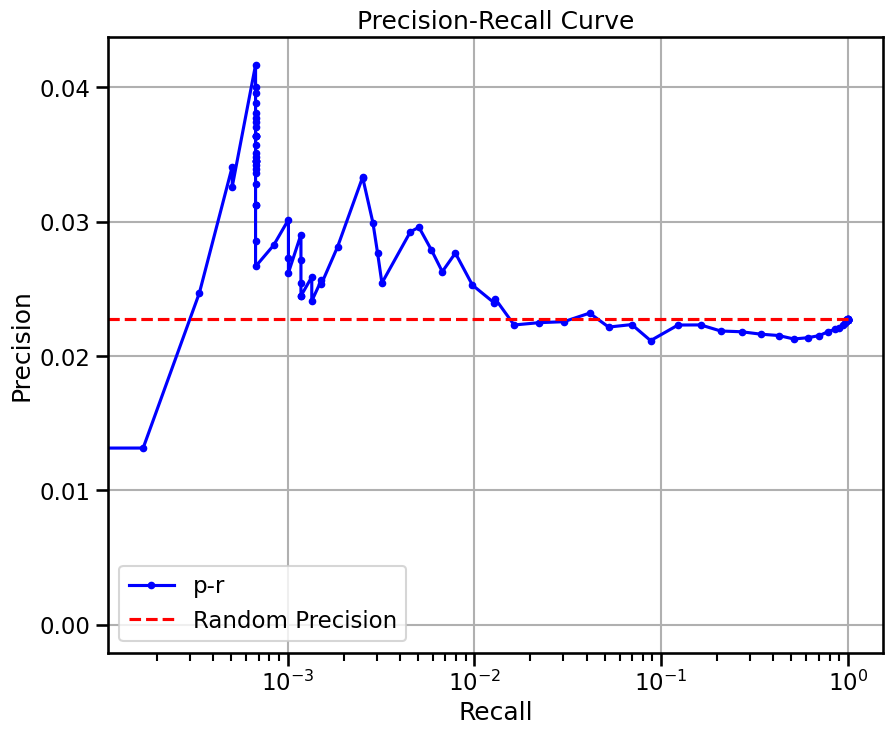

{'precision': 0.02272013481941093,
 'recall': 1.0,
 'rand_precision': 0.02272483488867436,
 'auprc': 0.02187076803680548,
 'epr': 1.0092955756831894}

In [18]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# Duren / all


In [10]:
preadata = get_sroy_gt(get="duren", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 464 renamining
filtered out 0 cells, 464 renamining
Removed 0 genes.
startin QC
Seeing 22 outliers (4.74% of total dataset):
done


(GRnnData object with n_obs × n_vars = 464 × 15299
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 7466 elements,
 44)

/tmp/ipykernel_1486605/1583948291.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 14620


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.006052861658484094 
recall:  1.0 
random precision: 0.006053268765133172


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 3413.59it/s]


Area Under Precision-Recall Curve (AUPRC):  0.006852799182253582
EPR: 1.8544375710137608


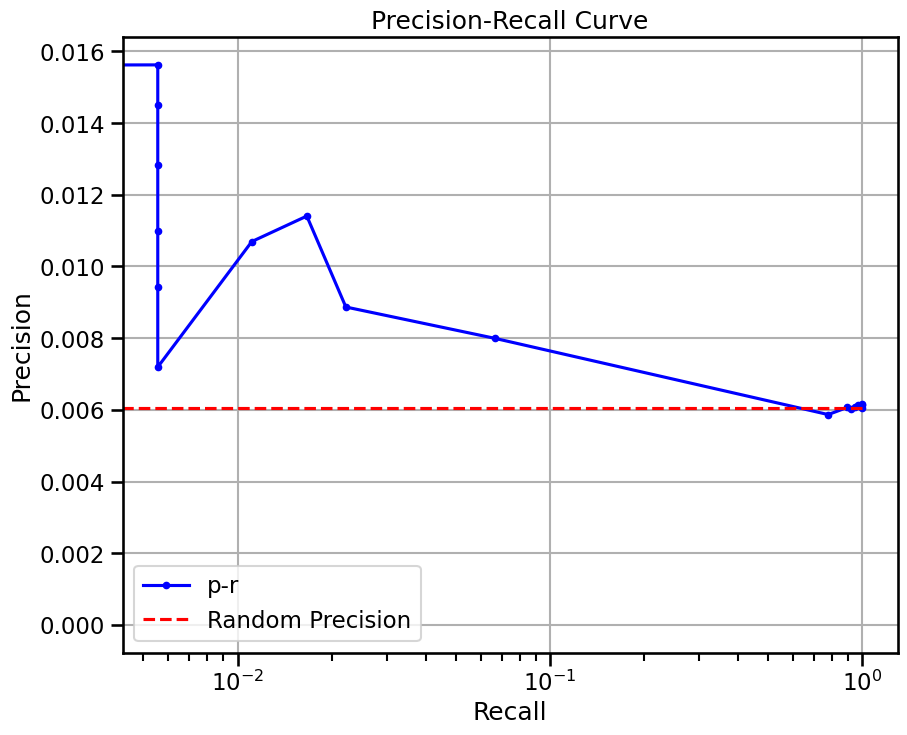

pred shape (6, 4957, 32)
true elem 180 ...
doing regression....


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:296: RuntimeWarning: invalid value encountered in long_scalars
  "precision": (pred[y_test == 1] == 1).sum() / (pred == 1).sum(),


metrics {'used_heads': 0, 'precision': nan, 'random_precision': 0.004101943379732365, 'recall': 0.0, 'predicted_true': 0.0, 'number_of_true': 61.0, 'epr': 0.0}


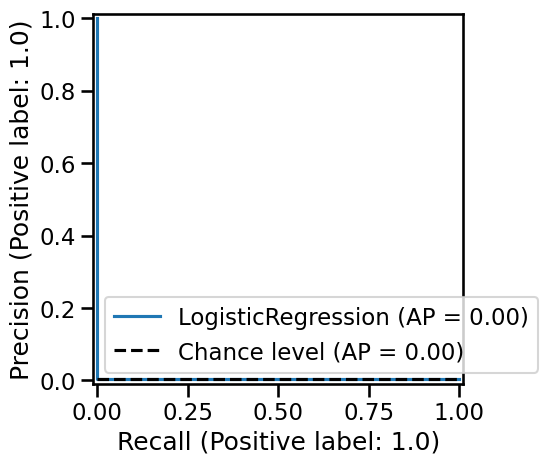

precision:  0.006052047609441194 
recall:  1.0 
random precision: 0.006053268765133172


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 3504.34it/s]


Area Under Precision-Recall Curve (AUPRC):  0.003026023804720597
EPR: 1.8544375710137608


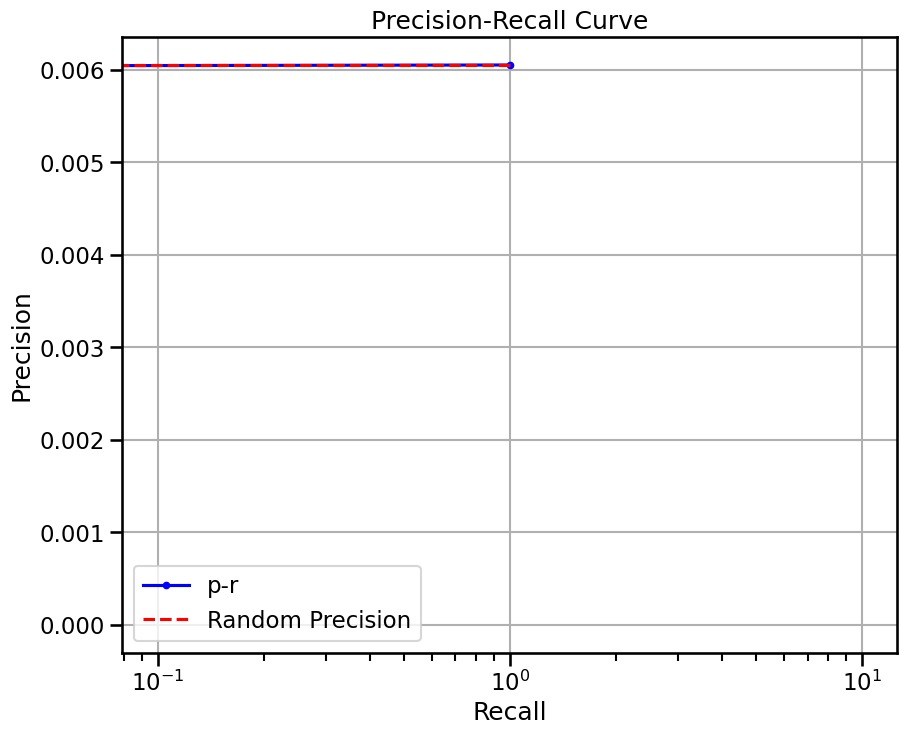

{'precision': 0.006052047609441194,
 'recall': 1.0,
 'rand_precision': 0.006053268765133172,
 'auprc': 0.003026023804720597,
 'EPR': 1.8544375710137608}

In [9]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

pred shape (6, 4957, 32)
true elem 180 ...
doing regression....
metrics {'used_heads': 1, 'precision': 0.0, 'random_precision': 0.00611929258287943, 'recall': 0.0, 'predicted_true': 6.0, 'number_of_true': 91.0, 'epr': 0.0}


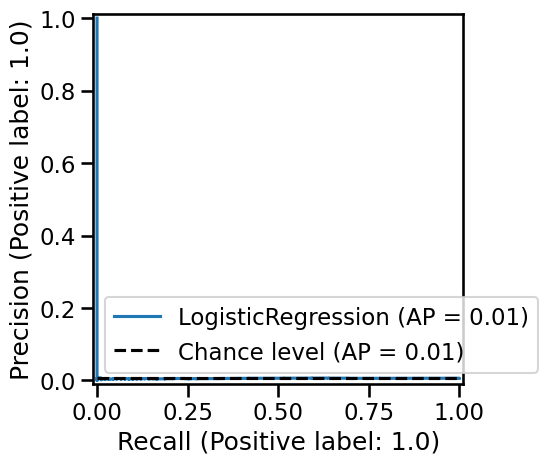

precision:  0.006052047609441194 
recall:  1.0 
random precision: 0.006053268765133172


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 6180.49it/s]


Area Under Precision-Recall Curve (AUPRC):  0.006709831498733423
EPR: 1.8544375710137608


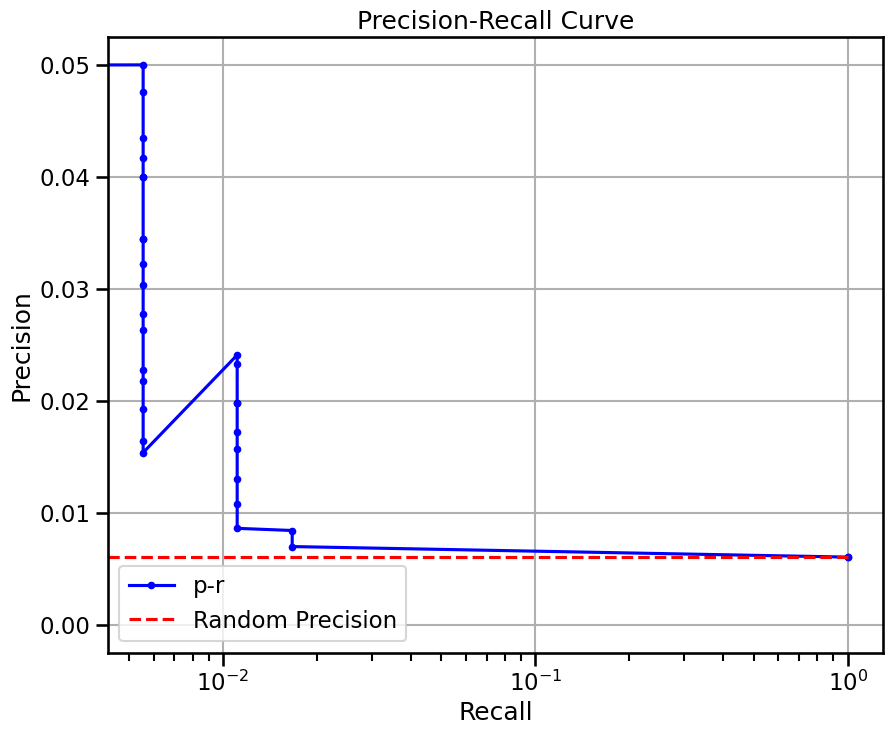

{'precision': 0.006052047609441194,
 'recall': 1.0,
 'rand_precision': 0.006053268765133172,
 'auprc': 0.006709831498733423,
 'EPR': 1.8544375710137608}

In [12]:
grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 100, 0: 1}, shuffle=True)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 14620


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24651225, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.006052047609441194 
recall:  1.0 
random precision: 0.006053268765133172


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 9102.26it/s]


Area Under Precision-Recall Curve (AUPRC):  0.005705009776771963
EPR: 0.0


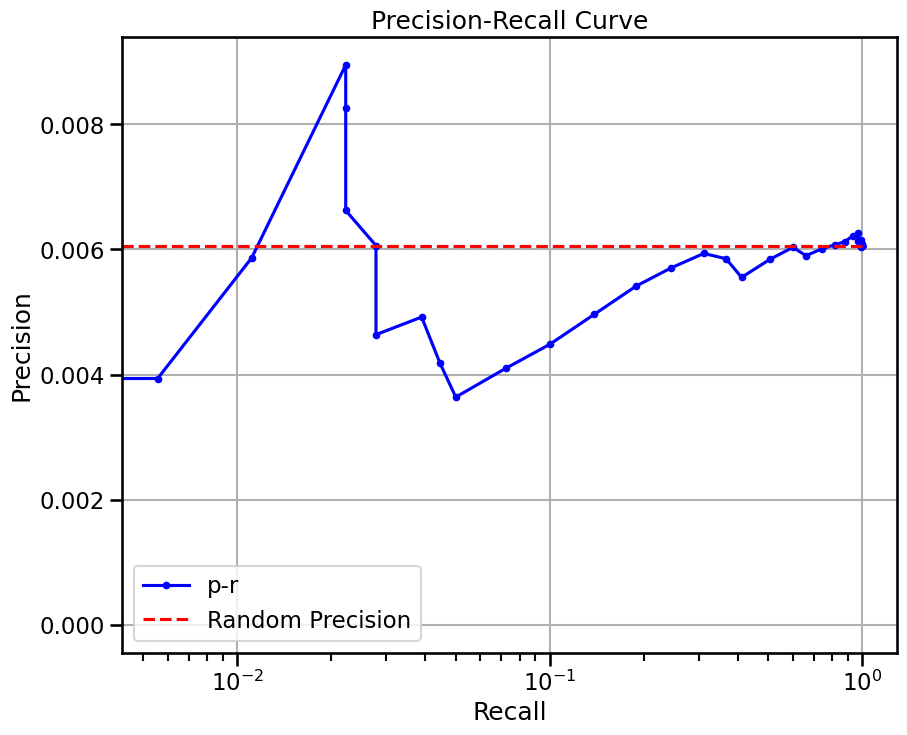

{'precision': 0.006052047609441194,
 'recall': 1.0,
 'rand_precision': 0.006053268765133172,
 'auprc': 0.005705009776771963,
 'EPR': 0.0}

In [16]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# semrau / all


In [17]:
preadata = get_sroy_gt(get="semrau", species="mouse", gt="full")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 384 renamining
filtered out 0 cells, 384 renamining
Removed 0 genes.
startin QC
Seeing 35 outliers (9.11% of total dataset):
done


(GRnnData object with n_obs × n_vars = 384 × 10243
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 4404 elements,
 38)

/tmp/ipykernel_1455512/2275473292.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.011163604969063264 
recall:  1.0 
random precision: 0.01116507765185585


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 1493.96it/s]


Area Under Precision-Recall Curve (AUPRC):  0.009831308739476075
EPR: 0.379491440414556


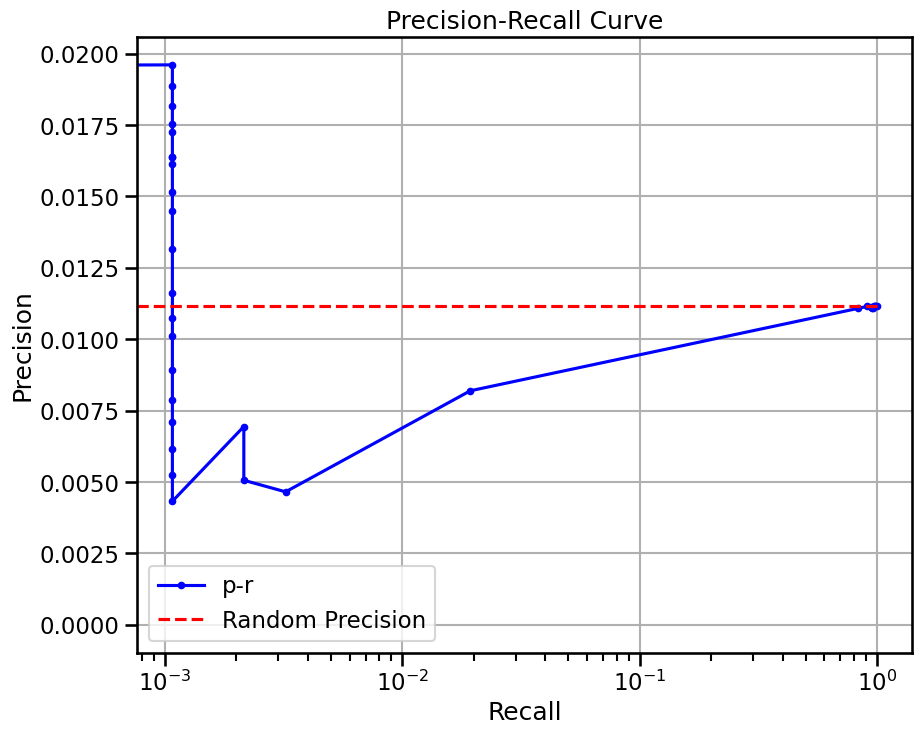

pred shape (17, 4906, 32)
true elem 931 ...
doing regression....
metrics {'used_heads': 3, 'precision': 0.004488530263315688, 'random_precision': 0.0044876845603096845, 'recall': 1.0, 'predicted_true': 58371.0, 'number_of_true': 262.0, 'epr': 3.4770746950303466}


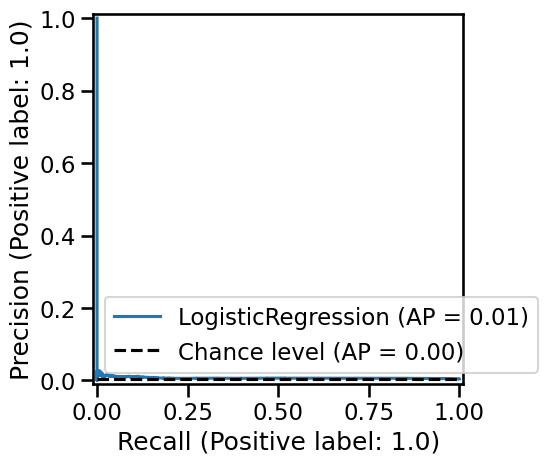

precision:  0.011162801851274549 
recall:  1.0 
random precision: 0.01116507765185585


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 3336.89it/s]


Area Under Precision-Recall Curve (AUPRC):  0.023538495734023224
EPR: 2.48368736264004


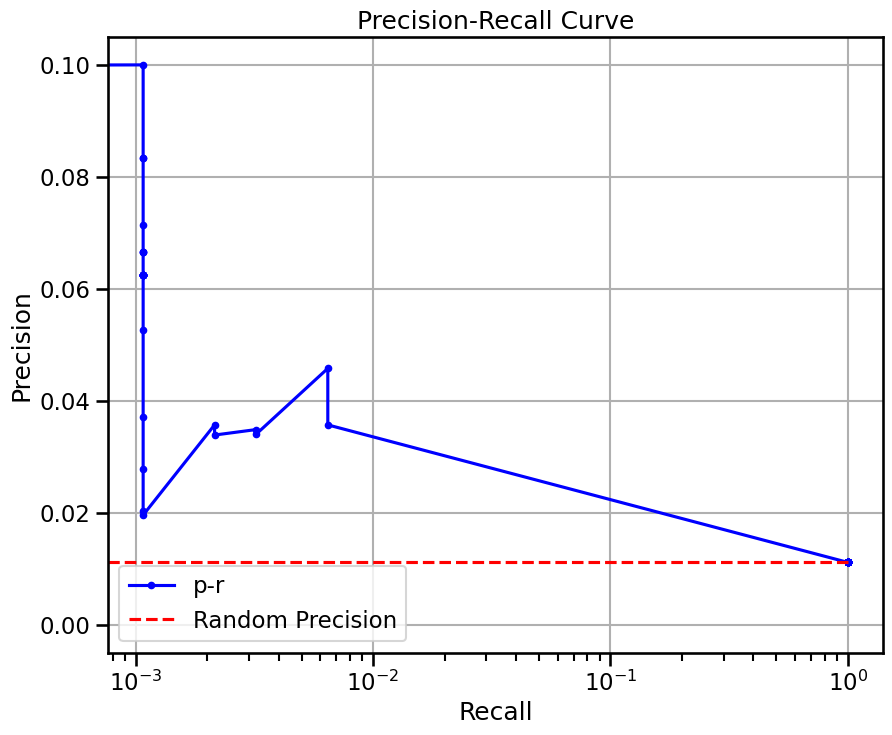

{'precision': 0.011162801851274549,
 'recall': 1.0,
 'rand_precision': 0.01116507765185585,
 'auprc': 0.023538495734023224,
 'EPR': 2.48368736264004}

In [20]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24147396, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.011162801851274549 
recall:  1.0 
random precision: 0.01116507765185585


  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 2877.79it/s]


Area Under Precision-Recall Curve (AUPRC):  0.012375446817455012
EPR: 1.059633742911153


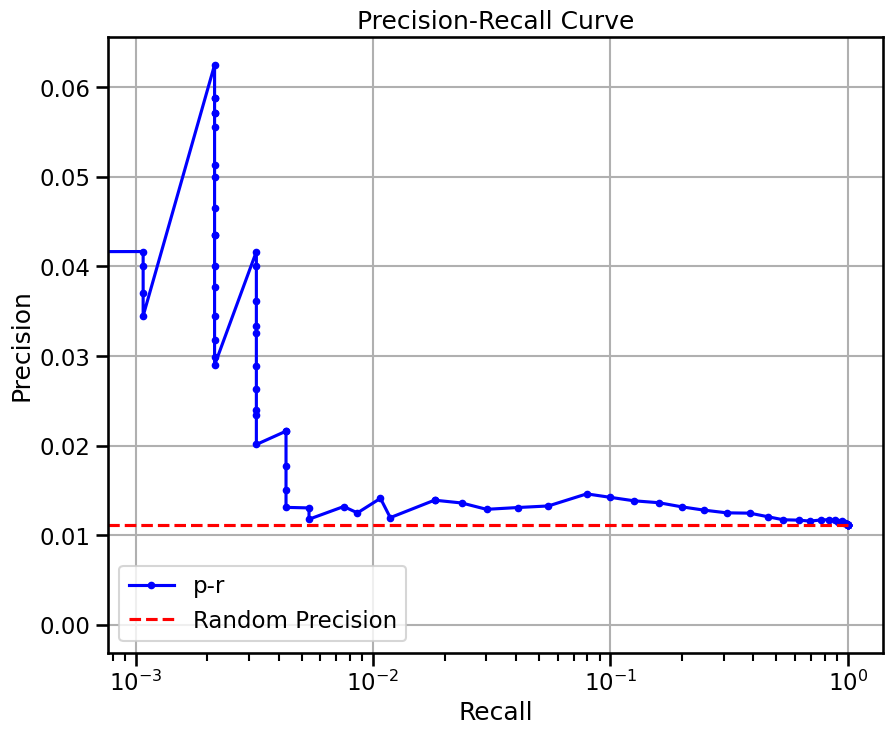

{'precision': 0.011162801851274549,
 'recall': 1.0,
 'rand_precision': 0.01116507765185585,
 'auprc': 0.012375446817455012,
 'EPR': 1.059633742911153}

In [21]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# semrau / chip


In [13]:
preadata = get_sroy_gt(get="semrau", species="mouse", gt="chip")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 384 renamining
filtered out 0 cells, 384 renamining
Removed 0 genes.
startin QC
Seeing 35 outliers (9.11% of total dataset):
done


(GRnnData object with n_obs × n_vars = 384 × 10243
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 94145 elements,
 49)

/tmp/ipykernel_1486605/1583948291.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.23262735185600425 
recall:  0.999868576685504 
random precision: 0.23269113149847095


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
 47%|████▋     | 47/99 [00:00<00:00, 468.88it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 545.56it/s]


Area Under Precision-Recall Curve (AUPRC):  0.22676660213126656
EPR: 1.1495841550037906


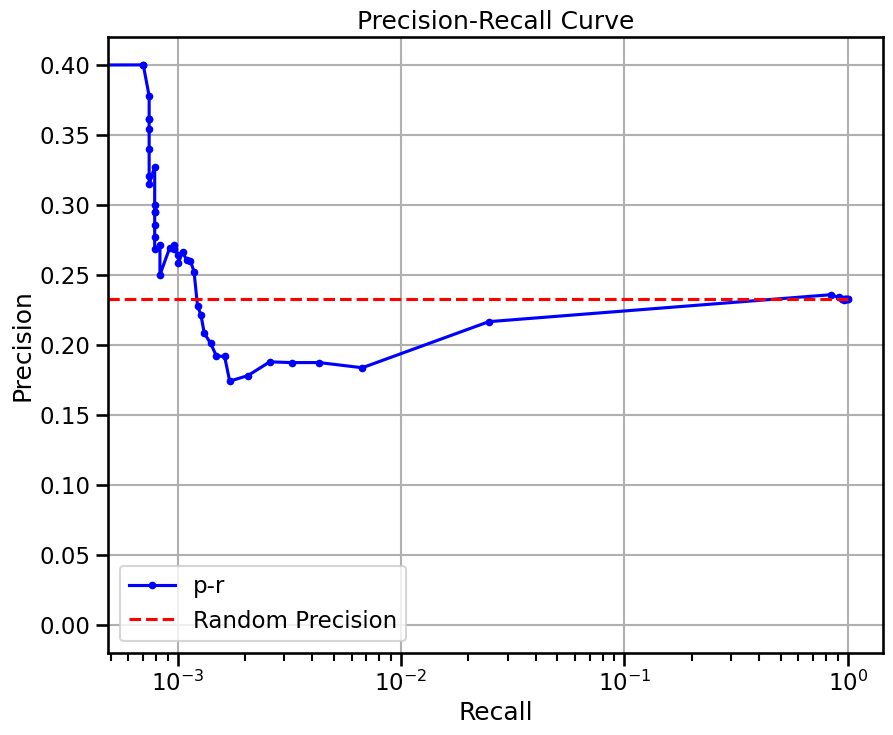

pred shape (20, 4906, 32)
true elem 22827 ...
doing regression....
metrics {'used_heads': 4, 'precision': 0.15167142274765594, 'random_precision': 0.15167142274765594, 'recall': 1.0, 'predicted_true': 49060.0, 'number_of_true': 7441.0, 'epr': 1.1093674557715698}


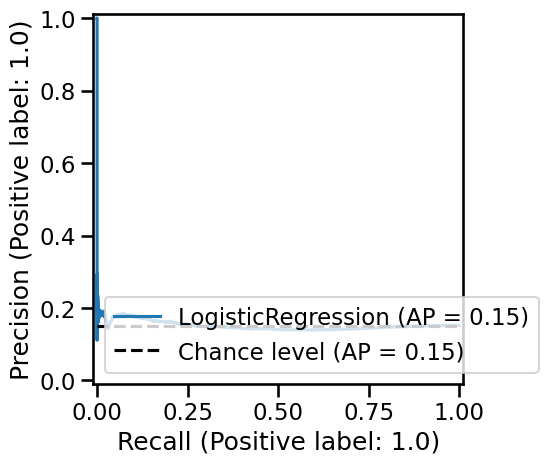

precision:  0.23264370158988992 
recall:  1.0 
random precision: 0.23269113149847095


 73%|███████▎  | 72/99 [00:00<00:00, 717.41it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 736.80it/s]


Area Under Precision-Recall Curve (AUPRC):  0.2778923680768983
EPR: 0.9199868092750005


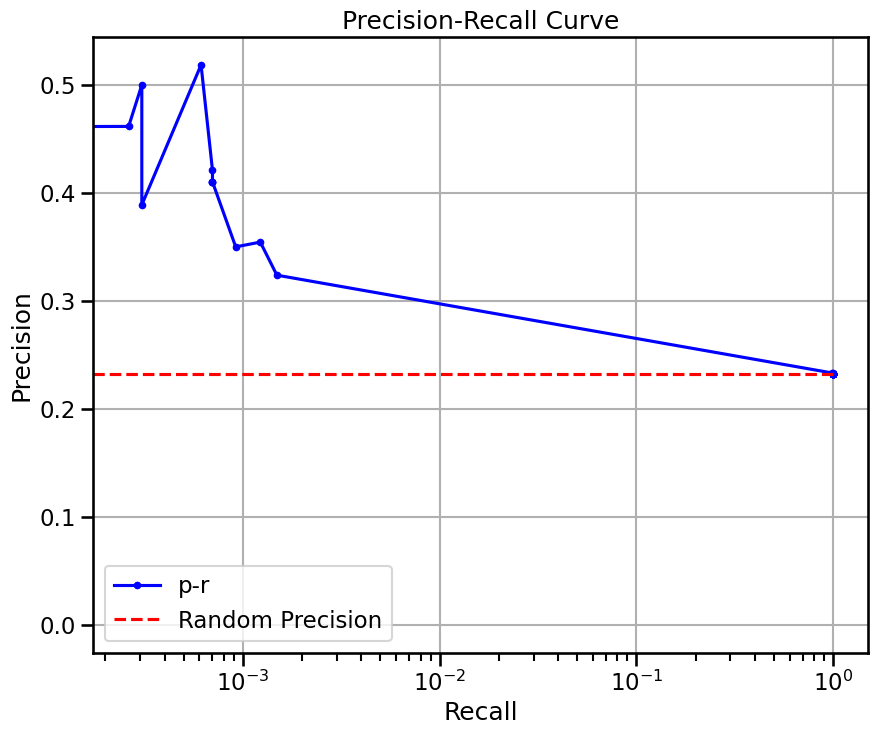

{'precision': 0.23264370158988992,
 'recall': 1.0,
 'rand_precision': 0.23269113149847095,
 'auprc': 0.2778923680768983,
 'EPR': 0.9199868092750005}

In [14]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24147396, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.23264370158988992 
recall:  1.0 
random precision: 0.23269113149847095


 64%|██████▎   | 63/99 [00:00<00:00, 626.42it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 650.97it/s]


Area Under Precision-Recall Curve (AUPRC):  0.23189476380859955
EPR: 0.9529574608865551


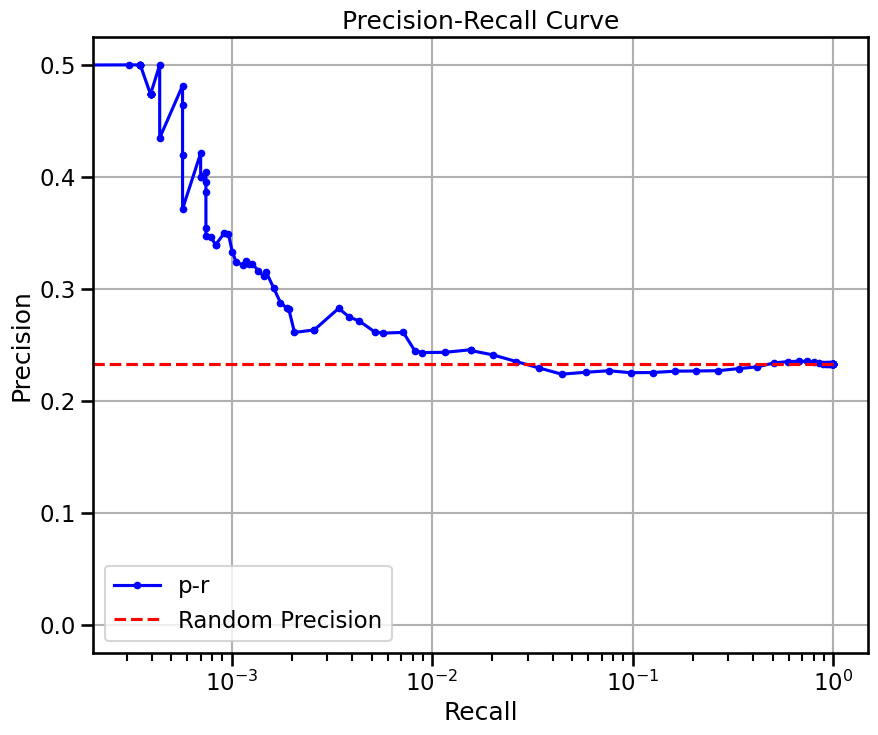

{'precision': 0.23264370158988992,
 'recall': 1.0,
 'rand_precision': 0.23269113149847095,
 'auprc': 0.23189476380859955,
 'EPR': 0.9529574608865551}

In [25]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

# semrau / ko


In [26]:
preadata = get_sroy_gt(get="semrau", species="mouse", gt="ko")
adata = preprocessor(preadata.copy())
adata.var["isTF"] = False
adata.var.loc[adata.var.symbol.isin(grnutils.mTF), "isTF"] = True
preadata, (preadata.grn.sum(1) != 0).sum()

/home/ml4ig1/Documents code/GRnnData/grnndata/GRNAnnData.py:218: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  da = np.zeros((len(varnames), len(varnames)), dtype=np.float)


Dropping layers:  KeysView(Layers with keys: )
checking raw counts
Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess
removed 0 non primary cells, 384 renamining
filtered out 0 cells, 384 renamining
Removed 0 genes.
startin QC
Seeing 35 outliers (9.11% of total dataset):
done


(GRnnData object with n_obs × n_vars = 384 × 10243
     obs: 'dataset', 'organism_ontology_term_id'
     varp: 'GRN'
     with a grn of 39782 elements,
 125)

In [15]:
import joblib

In [16]:
clf = joblib.load('/tmp/classifier.pkl')

/tmp/ipykernel_1455512/2725712659.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.03119419354468249 
recall:  1.0 
random precision: 0.03119840346872263


/home/ml4ig1/Documents code/benGRN/bengrn/base.py:675: RuntimeWarning: divide by zero encountered in log10
  thresholds = np.logspace(np.log10(grn.min()), np.log10(grn.max()), 50)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
  0%|          | 0/99 [00:00<?, ?it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 756.33it/s]


Area Under Precision-Recall Curve (AUPRC):  0.030679908651916516
EPR: 0.95933128827225


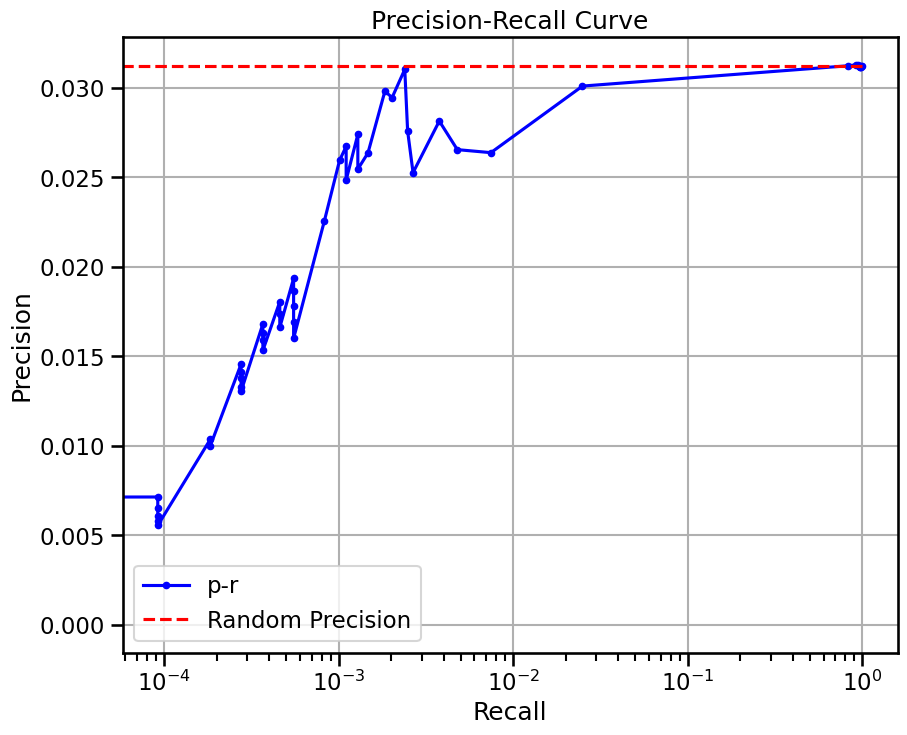

pred shape (71, 4906, 32)
true elem 10865 ...
doing regression....
metrics {'used_heads': 10, 'precision': 0.024623464984111113, 'random_precision': 0.024620614022496167, 'recall': 0.9993003731343284, 'predicted_true': 174021.0, 'number_of_true': 4288.0, 'epr': 1.3381924609803266}


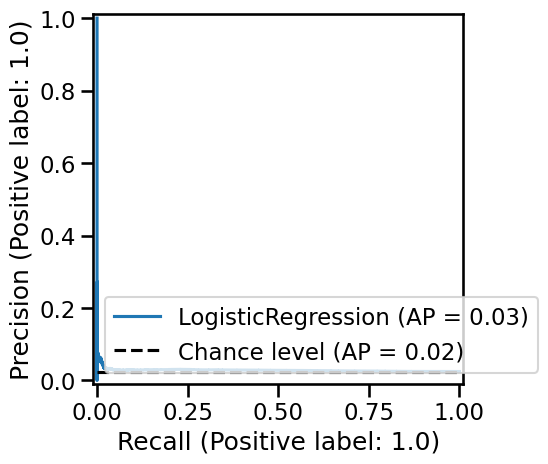

precision:  0.031192044234424073 
recall:  1.0 
random precision: 0.03119840346872263


 94%|█████████▍| 93/99 [00:00<00:00, 474.40it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 453.35it/s]


Area Under Precision-Recall Curve (AUPRC):  0.04664458021867715
EPR: 1.190853229747904


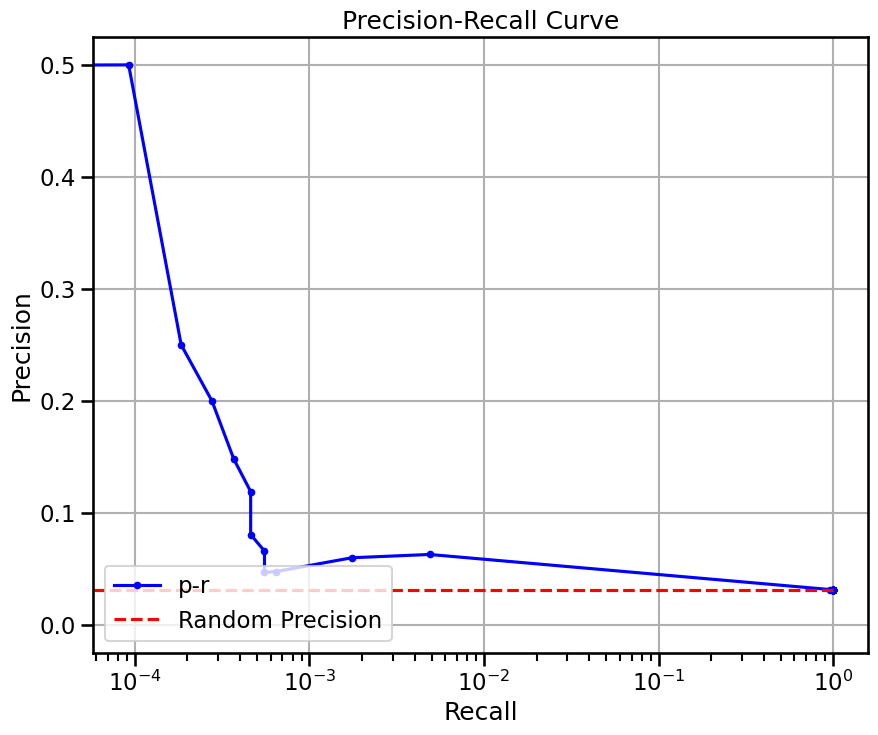

{'precision': 0.031192044234424073,
 'recall': 1.0,
 'rand_precision': 0.03119840346872263,
 'auprc': 0.04664458021867715,
 'EPR': 1.190853229747904}

In [27]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='none',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.varp["classified"] = clf_omni.predict_proba(
    grn.varp['GRN'].reshape(-1, grn.varp['GRN'].shape[-1])
).reshape(len(grn.var), len(grn.var), 2)[:, :, 1]
grn.varp['all'] = grn.varp['GRN']
grn.varp['GRN'] = grn.varp['classified']
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

grn.varp['GRN'] = grn.varp['all']
grn.var.index = grn.var['ensembl_id']
grn, m, _ = train_classifier(grn, other=preadata, C=0.5, train_size=0.5, class_weight={
                             1: 40, 0: 1}, shuffle=False)
grn.varp['GRN'] = grn.varp['classified']
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)

/tmp/ipykernel_1455512/590398501.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=adata.obs['organism_ontology_term_id'][0],
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


number of expressed genes in this cell type: 9459


/home/ml4ig1/Documents code/scPRINT/scprint/tasks/grn.py:167: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  organisms=[subadata.obs['organism_ontology_term_id'][0]],
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

avg link count: 24147396, sparsity: 1.0


... storing 'dataset' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'ncbi_gene_ids' as categorical
... storing 'biotype' as categorical
... storing 'synonyms' as categorical
... storing 'organism' as categorical


precision:  0.031192044234424073 
recall:  1.0 
random precision: 0.03119840346872263


 48%|████▊     | 48/99 [00:00<00:00, 474.67it/s]/home/ml4ig1/Documents code/benGRN/bengrn/base.py:681: RuntimeWarning: invalid value encountered in long_scalars
  precision = (grn[true] > threshold).sum() / (grn > threshold).sum()
100%|██████████| 99/99 [00:00<00:00, 527.69it/s]


Area Under Precision-Recall Curve (AUPRC):  0.030854789771348194
EPR: 1.1204012133150174


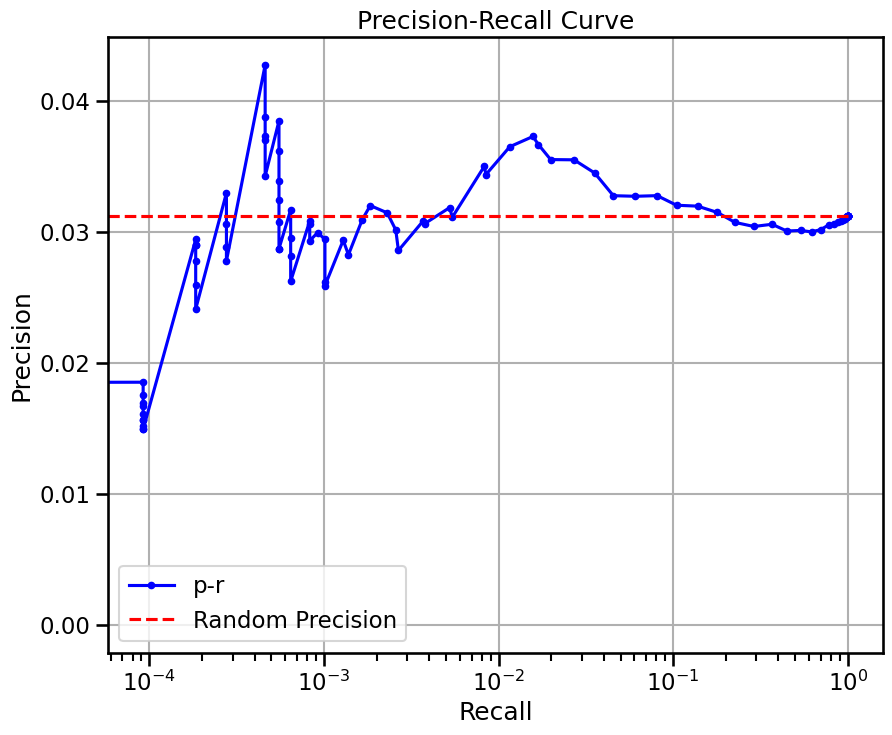

{'precision': 0.031192044234424073,
 'recall': 1.0,
 'rand_precision': 0.03119840346872263,
 'auprc': 0.030854789771348194,
 'EPR': 1.1204012133150174}

In [28]:
grn_inferer = GRNfer(model, adata,
                     how="most var within",
                     preprocess="softmax",
                     head_agg='max',
                     filtration="none",
                     forward_mode="none",
                     organisms=adata.obs['organism_ontology_term_id'][0],
                     apc=False,
                     symmetrize=False,
                     num_genes=MAXGENES,
                     max_cells=64,
                     doplot=False,
                     batch_size=32,
                     )
grn = grn_inferer(layer=list(range(model.nlayers))[:])
grn.var['ensembl_id'] = grn.var.index
grn.var['symbol'] = make_index_unique(grn.var['symbol'].astype(str))
grn.var.index = grn.var['symbol']
BenGRN(grn, do_auc=True, doplot=True).compare_to(other=preadata)